In [7]:
import os
from pathlib import Path

# Function to save the figure to the desired directory
def save_figure(fig, filename, target_dir: Path=Path("../../tex/figures/za-evaluation")):
    # Ensure target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # Construct the full path
    file_path = os.path.join(target_dir, filename)
    
    # Save the figure
    fig.savefig(file_path)
    print(f"Figure saved to {file_path}")

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load DOCA compression/decompression results

# Define the base path to the doca directory
base_path = 'results/doca'

# Columns in DOCA csvs
cols_old = [
    'Configuration', 'Dataset', 'Filename', 'Input Size (bytes)', 
    'Output Size (bytes)', 'Dest. DOCA Buffer (bytes)', 'Total Time (seconds)',
    'Task Time (seconds)', 'Mem Time (seconds)',
    'Concurrent # of Tasks', 'Task + Mem Throughput (MB/s)', 'Task Throughput (MB/s)', 'Error (bool)'
]

cols = [
    'Configuration', 'Dataset', 'Filename', 'Input Size (bytes)', 'Output Size (bytes)',
    'DOCA Buffer (bytes)', 'DOCA Buffers (num)', 'Total Time (seconds)',
    'Task Time (seconds)', 'Ctx Task Time (seconds)', 'Mem Time (seconds)', 'Dev Time (seconds)',
    'Cb Task Time (seconds)', 'Cb Task Throughput (MB/s)', 'Task Throughput (MB/s)',
    'Cb Task Start Latency (seconds)', 'Cb Task End Latency (seconds)'
]

# Go over all bluefield models
doca_per_device_results = {"bf2": {"dflt": []}, "bf3": {"dflt": [], "lz4": []}}
for bf_dir in doca_per_device_results.keys():
    cwd_dir = base_path + os.sep + bf_dir
    for algo in doca_per_device_results[bf_dir].keys():
        # Use glob to find the 'orig' CSV file in the latest directory
        orig_csv_path = glob.glob(f'{cwd_dir}/2.9/*orig*{algo}.csv')[0]
        orig_df = pd.read_csv(orig_csv_path, header=None, names=cols)
        orig_df.index.name = 'orig'
        # Use glob to find the 'variable' CSV file
        variable_csv_path = glob.glob(f'{cwd_dir}/2.9/*variable*{algo}.csv')[0]
        var_df = pd.read_csv(variable_csv_path, header=None, names=cols)
        var_df.index.name = 'var'

        for current_df in [orig_df, var_df]:
            # Filter for any errors and print the errors
            if (current_df.drop(columns=['Configuration', 'Dataset', 'Filename']).values < 0).any():
                print("Rows with errors")

            # Drop the 'unnecesary' columns since we are focusing on a single dataset for now
            current_df = current_df.drop(columns=['Dataset'])
            doca_per_device_results[bf_dir][algo].append(current_df)

In [2]:
# 2. Load CPU-based results, both host and DPU
# Define the base path to the CPU directory
base_path = 'results/cpu'

# Define the cols to drop
cols_to_drop = ['codec', 'param', 'cmem', 'dmem', 'cstack', 'dstack', 'time']

# Get all names from the dirs
cpu_per_device_results = {d: {"dflt": [], "libdeflate": [], "lz4": []} for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))}

for device in cpu_per_device_results.keys():
    current_dir = os.path.join(base_path, device)
    # Use glob to find the 'orig' CSV file in the latest directory
    orig_cpu_csv_paths = glob.glob(f'{current_dir}/*orig*.csv')
    # Use glob to find the 'variable' CSV file in the latest directory
    var_cpu_csv_paths = glob.glob(f'{current_dir}/*variable*.csv')
    for current_path in orig_cpu_csv_paths + var_cpu_csv_paths:
        cpu_df = pd.read_csv(current_path, sep="\\s+")
        cpu_df.drop(columns=cols_to_drop, inplace=True)
        if "orig" in current_path:
            cpu_df.index.name = "orig"
        else:
            cpu_df.index.name = "var"
        for algo in cpu_per_device_results[device].keys():
            if algo in current_path:
                cpu_per_device_results[device][algo].append(cpu_df)
    assert(len({len(v) for v in cpu_per_device_results[device].values()}) == 1)
    assert(len(cpu_per_device_results[device][algo]) == 2)  # whatever the last one might be


In [3]:
# DEFLATE Compression time breakdown
time_breakdown_res = {"dflt": [], "ddflt": []}

## Average that combines cpu + doca for DEFLATE
for device in doca_per_device_results.keys():
    if "bf3" in device:
        continue
    orig_dflt_results = doca_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results = orig_dflt_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'CDFLT']
    orig_dflt_results = orig_dflt_results.rename(columns={"Filename": "dataset", 
                                                          "Task Throughput (MB/s)": "e2e_mbps",
                                                          'Cb Task Throughput (MB/s)': "cb_mbps",
                                                          "Total Time (seconds)": "total_time",
                                                          'Task Time (seconds)': "e2e_time",
                                                          "Ctx Task Time (seconds)": "ctx_time",
                                                          "Mem Time (seconds)": "mem_time",
                                                          "Dev Time (seconds)": "dev_time",
                                                          "Cb Task Time (seconds)": "cb_time",
                                                          "Cb Task Start Latency (seconds)": "cb_start",
                                                          "Cb Task End Latency (seconds)": "cb_end"})
    orig_dflt_results = orig_dflt_results[["e2e_mbps", "cb_mbps", "ctx_time", "mem_time", "dev_time", 
                                           "cb_time", "cb_start", "cb_end"]]
    orig_dflt_results = orig_dflt_results.mean()
    orig_dflt_results["agg_time"] = orig_dflt_results["dev_time"] + orig_dflt_results["mem_time"] \
                                    + orig_dflt_results["ctx_time"] + orig_dflt_results["cb_time"] \
                                    + orig_dflt_results["cb_end"] - orig_dflt_results["cb_start"]
    mean_df = orig_dflt_results.to_frame().T
    mean_df["device"] = device
    time_breakdown_res["dflt"] = mean_df
display(time_breakdown_res["dflt"])
time_breakdown_res["dflt"].to_csv(f"../../tex/figures/za-evaluation/time-breakdown-dflt.csv",index=False)

## Average that combines cpu + doca for decompress DEFLATE
for device in doca_per_device_results.keys():
    orig_dflt_results = doca_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results = orig_dflt_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'DDFLT']
    orig_dflt_results = orig_dflt_results.rename(columns={"Filename": "dataset", 
                                                          "Task Throughput (MB/s)": "e2e_mbps",
                                                          'Cb Task Throughput (MB/s)': "cb_mbps",
                                                          "Total Time (seconds)": "total_time",
                                                          'Task Time (seconds)': "e2e_time",
                                                          "Ctx Task Time (seconds)": "ctx_time",
                                                          "Mem Time (seconds)": "mem_time",
                                                          "Dev Time (seconds)": "dev_time",
                                                          "Cb Task Time (seconds)": "cb_time",
                                                          "Cb Task Start Latency (seconds)": "cb_start",
                                                          "Cb Task End Latency (seconds)": "cb_end"})
    orig_dflt_results = orig_dflt_results[["e2e_mbps", "cb_mbps", "ctx_time", "mem_time", "dev_time", 
                                           "cb_time", "cb_start", "cb_end"]]
    orig_dflt_results = orig_dflt_results.mean()
    orig_dflt_results["agg_time"] = orig_dflt_results["dev_time"] + orig_dflt_results["mem_time"] \
                                    + orig_dflt_results["ctx_time"] + orig_dflt_results["cb_time"] \
                                    + orig_dflt_results["cb_end"] - orig_dflt_results["cb_start"]
    mean_df = orig_dflt_results.to_frame().T
    mean_df["device"] = device
    time_breakdown_res["ddflt"].append(mean_df)
ddflate_results = pd.concat(time_breakdown_res["ddflt"], ignore_index=True)
ddflate_results.to_csv(f"../../tex/figures/za-evaluation/time-breakdown-ddflt.csv",index=False)
display(ddflate_results)

## Average that combines cpu + doca for decompress LZ4
for device in doca_per_device_results.keys():
    if "bf2" in device:
        continue
    orig_lz4_results = doca_per_device_results[device]["lz4"][0]
    assert orig_lz4_results.index.name == "orig"
    orig_lz4_results = orig_lz4_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_lz4_results = orig_lz4_results[orig_lz4_results['Configuration'] == 'DLZ4']
    orig_lz4_results = orig_lz4_results.rename(columns={"Filename": "dataset", 
                                                          "Task Throughput (MB/s)": "e2e_mbps",
                                                          'Cb Task Throughput (MB/s)': "cb_mbps",
                                                          "Total Time (seconds)": "total_time",
                                                          'Task Time (seconds)': "e2e_time",
                                                          "Ctx Task Time (seconds)": "ctx_time",
                                                          "Mem Time (seconds)": "mem_time",
                                                          "Dev Time (seconds)": "dev_time",
                                                          "Cb Task Time (seconds)": "cb_time",
                                                          "Cb Task Start Latency (seconds)": "cb_start",
                                                          "Cb Task End Latency (seconds)": "cb_end"})
    orig_lz4_results = orig_lz4_results[["e2e_mbps", "cb_mbps", "ctx_time", "mem_time", "dev_time", 
                                           "cb_time", "cb_start", "cb_end"]]
    orig_lz4_results = orig_lz4_results.mean()
    orig_lz4_results["agg_time"] = orig_lz4_results["dev_time"] + orig_lz4_results["mem_time"] \
                                    + orig_lz4_results["ctx_time"] + orig_lz4_results["cb_time"] \
                                    + orig_lz4_results["cb_end"] - orig_lz4_results["cb_start"]
    mean_df = orig_lz4_results.to_frame().T
    mean_df["device"] = device
    time_breakdown_res["lz4"] = mean_df
lz4_results = time_breakdown_res["lz4"]
lz4_results.to_csv(f"../../tex/figures/za-evaluation/time-breakdown-dlz4.csv",index=False)
display(lz4_results)

,e2e_mbps,cb_mbps,ctx_time,mem_time,dev_time,cb_time,cb_start,cb_end,agg_time,device
0,137.682724,2703.56302,0.259069,0.01471,0.003882,0.006163,0.000009,0.111245,0.395059,bf2


,e2e_mbps,cb_mbps,ctx_time,mem_time,dev_time,cb_time,cb_start,cb_end,agg_time,device
0,50.011425,1276.904970,0.259608,0.012472,0.003788,0.004660,0.000009,0.111594,0.392113,bf2
1,72.893573,1848.037344,0.218892,0.009760,0.003266,0.003833,0.000003,0.102509,0.338256,bf3


,e2e_mbps,cb_mbps,ctx_time,mem_time,dev_time,cb_time,cb_start,cb_end,agg_time,device
0,92.109546,4125.119174,0.218527,0.010179,0.003309,0.002267,0.000003,0.102442,0.33672,bf3


In [4]:
# DEFLATE Compression figure CSV for tikz
results = {"dflt": [], "lz4": [], "libdeflate": []}

## Average that combines cpu + doca for DEFLATE
for device in doca_per_device_results.keys():
    orig_dflt_results = doca_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results = orig_dflt_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'CDFLT']
    orig_dflt_results = orig_dflt_results.rename(columns={"Filename": "dataset", 
                                                          "Task Throughput (MB/s)": "compression_mbps",
                                                          "Input Size (bytes)": "size",
                                                          "Output Size (bytes)": "csize"})
    orig_dflt_results["device"] = device
    orig_dflt_results["reduction_percentage"] = 100.0 - ((orig_dflt_results["csize"] / orig_dflt_results["size"]) * 100)
    orig_dflt_results = orig_dflt_results[["dataset", "compression_mbps", "device", "reduction_percentage"]]
    results["dflt"].append(orig_dflt_results)

for device in cpu_per_device_results.keys():
    orig_dflt_results = cpu_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results["compression_mbps"] = (orig_dflt_results["size"] / 1_048_576) / orig_dflt_results["ctime"]
    orig_dflt_results["device"] = device
    orig_dflt_results["algo"] = "dflt-" + orig_dflt_results["level"].astype(str)
    orig_dflt_results["reduction_percentage"] = 100.0 - ((orig_dflt_results["csize"] / orig_dflt_results["size"]) * 100)
    orig_dflt_results = orig_dflt_results[["dataset", "compression_mbps", "device", "reduction_percentage"]]
    results["dflt"].append(orig_dflt_results)

# Concatenate all dataframes in results["dflt"], prepare per-file DEFLATE
df_dflt = pd.concat(results["dflt"], ignore_index=True)
df_dflt_per_device = df_dflt.groupby(['device', 'dataset'], as_index=False).agg({"compression_mbps": "mean"})
dflt_pivoted = df_dflt_per_device.pivot(index="dataset", columns="device", values="compression_mbps")
dflt_pivoted.reset_index(inplace=True)  # make 'dataset' into a normal column again
dflt_pivoted.to_csv(f"../../tex/figures/za-evaluation/comp-dflt.csv", index=False)

# Prepare per-device results for all algos
df_dflt_per_algo = df_dflt.groupby(['device'], as_index=False).agg({"compression_mbps": "mean", 
                                                                    "reduction_percentage": "mean"})
df_dflt_per_algo["algo"] = "dflt"

## Average from cpu for libdeflate as well as per-compression-level preparation
for device in cpu_per_device_results.keys():
    orig_libdeflate_results = cpu_per_device_results[device]["libdeflate"][0]
    assert orig_libdeflate_results.index.name == "orig"
    orig_libdeflate_results = orig_libdeflate_results[orig_libdeflate_results["level"] != 2]
    orig_libdeflate_results["compression_mbps"] = (orig_libdeflate_results["size"] / 1_048_576) / orig_libdeflate_results["ctime"]
    orig_libdeflate_results["device"] = device
    orig_libdeflate_results["algo"] = "libdeflate-" + orig_libdeflate_results["level"].astype(str)
    orig_libdeflate_results["reduction_percentage"] = 100.0 - ((orig_libdeflate_results["csize"] / orig_libdeflate_results["size"]) * 100)
    orig_libdeflate_results = orig_libdeflate_results[["dataset", "compression_mbps", "reduction_percentage", "device", "algo"]]
    results["libdeflate"].append(orig_libdeflate_results)

# Concatenate all dataframes in results["libdeflate"]
df_libdeflate = pd.concat(results["libdeflate"], ignore_index=True)

# Prepare libdeflate per-device results for all algos
df_libdeflate_per_algo = df_libdeflate.groupby(['device', 'algo'], as_index=False).agg({"compression_mbps": "mean",
                                                                                        "reduction_percentage": "mean"})

## Average from cpu for LZ4 as well as per-compression-level preparation
for device in cpu_per_device_results.keys():
    orig_lz4_results = cpu_per_device_results[device]["lz4"][0]
    assert orig_lz4_results.index.name == "orig"
    orig_lz4_results = orig_lz4_results[orig_lz4_results["level"] != 6]
    orig_lz4_results["compression_mbps"] = (orig_lz4_results["size"] / 1_048_576) / orig_lz4_results["ctime"]
    orig_lz4_results["device"] = device
    orig_lz4_results["algo"] = "lz4-" + orig_lz4_results["level"].astype(str)
    orig_lz4_results["reduction_percentage"] = 100.0 - ((orig_lz4_results["csize"] / orig_lz4_results["size"]) * 100)
    orig_lz4_results = orig_lz4_results[["dataset", "compression_mbps", "reduction_percentage", "device", "algo"]]
    results["lz4"].append(orig_lz4_results)

# Concatenate all dataframes in results["lz4"]
df_lz4 = pd.concat(results["lz4"], ignore_index=True)

# Prepare LZ4 per-device results for all algos
df_lz4_per_algo = df_lz4.groupby(['device', 'algo'], as_index=False).agg({"compression_mbps": "mean",
                                                                          "reduction_percentage": "mean"})

# Concatenate, pivot, write the per-algo averages
df_all_algos = pd.concat([df_dflt_per_algo, df_libdeflate_per_algo, df_lz4_per_algo], ignore_index=True)
df_all_algos.to_csv(f"../../tex/figures/za-evaluation/compression-tradeoff.csv", index=False)

# Per-algo throughput perf
df_all_algos = pd.concat([df_dflt_per_algo, df_libdeflate_per_algo, df_lz4_per_algo], ignore_index=True)
all_algos_pivoted = df_all_algos.pivot(index="algo", columns="device", values="compression_mbps")
all_algos_pivoted.fillna(0, inplace=True)
all_algos_pivoted.to_csv(f"../../tex/figures/za-evaluation/comp-algos-avg.csv")

/tmp/ipykernel_57240/137128371.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_libdeflate_results["compression_mbps"] = (orig_libdeflate_results["size"] / 1_048_576) / orig_libdeflate_results["ctime"]
/tmp/ipykernel_57240/137128371.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_libdeflate_results["device"] = device
/tmp/ipykernel_57240/137128371.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [5]:
# per-file analysis on decompression (deflate-3 and lz4-{1,3})
## DEFLATE Decompression figure CSV for tikz
results = {"dflt": [], "lz4": [], "libdeflate": []}

## Average that combines cpu + doca for DEFLATE in HW
for device in doca_per_device_results.keys():
    orig_dflt_results = doca_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results = orig_dflt_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'DDFLT']
    orig_dflt_results = orig_dflt_results.rename(columns={"Filename": "dataset", 
                                                          "Task Throughput (MB/s)": "decompression_mbps",
                                                          "Input Size (bytes)": "size"})
    orig_dflt_results["device"] = device
    orig_dflt_results = orig_dflt_results[["dataset", "decompression_mbps", "device"]]
    results["dflt"].append(orig_dflt_results)

for device in cpu_per_device_results.keys():
    orig_dflt_results = cpu_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results["decompression_mbps"] = (orig_dflt_results["csize"] / 1_048_576) / orig_dflt_results["dtime"]
    orig_dflt_results["device"] = device
    orig_dflt_results["algo"] = "dflt-" + orig_dflt_results["level"].astype(str)
    orig_dflt_results = orig_dflt_results[["dataset", "decompression_mbps", "device"]]
    results["dflt"].append(orig_dflt_results)

# Concatenate all dataframes in results["dflt"], prepare per-file DEFLATE
df_dflt = pd.concat(results["dflt"], ignore_index=True)
df_dflt_per_device = df_dflt.groupby(['device', 'dataset'], as_index=False).agg({"decompression_mbps": "mean"})
dflt_pivoted = df_dflt_per_device.pivot(index="dataset", columns="device", values="decompression_mbps")
dflt_pivoted.reset_index(inplace=True)  # make 'dataset' into a normal column again
dflt_pivoted.fillna(0, inplace=True)
dflt_pivoted.to_csv(f"../../tex/figures/za-evaluation/decomp-dflt.csv", index=False)
column_order = dflt_pivoted.columns.tolist()

## Average that combines cpu + doca for LZ4 in HW
devices_missing_lz4 = []
for device in doca_per_device_results.keys():
    if device == "bf2":
        devices_missing_lz4.append(device)
        continue
    orig_lz4_results = doca_per_device_results[device]["lz4"][0]
    assert orig_lz4_results.index.name == "orig"
    orig_lz4_results = orig_lz4_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_lz4_results = orig_lz4_results[orig_lz4_results['Configuration'] == 'DLZ4']
    orig_lz4_results = orig_lz4_results.rename(columns={"Filename": "dataset", 
                                                        "Task Throughput (MB/s)": "decompression_mbps",
                                                        "Input Size (bytes)": "size"})
    orig_lz4_results["device"] = device
    orig_lz4_results = orig_lz4_results[["dataset", "decompression_mbps", "device"]]
    results["lz4"].append(orig_lz4_results)

for device in cpu_per_device_results.keys():
    orig_lz4_results = cpu_per_device_results[device]["lz4"][0]
    assert orig_lz4_results.index.name == "orig"
    orig_lz4_results = orig_lz4_results[orig_lz4_results["level"] != 6]
    orig_lz4_results["decompression_mbps"] = (orig_lz4_results["csize"] / 1_048_576) / orig_lz4_results["dtime"]
    orig_lz4_results = orig_lz4_results.groupby(["dataset"], as_index=False).agg(
                                                                    {"decompression_mbps": "mean"})
    orig_lz4_results["device"] = device
    orig_lz4_results = orig_lz4_results[["dataset", "decompression_mbps", "device"]]
    results["lz4"].append(orig_lz4_results)

# Concatenate all dataframes in results["lz4"], prepare per-file DEFLATE
df_lz4 = pd.concat(results["lz4"], ignore_index=True)
lz4_pivoted = df_lz4.pivot(index="dataset", columns="device", values="decompression_mbps")
lz4_pivoted.reset_index(inplace=True)  # make 'dataset' into a normal column again
for device in devices_missing_lz4:
    lz4_pivoted[device] = 1
lz4_pivoted = lz4_pivoted[column_order]
lz4_pivoted.to_csv(f"../../tex/figures/za-evaluation/decomp-lz4.csv", index=False)

/tmp/ipykernel_57240/291484354.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_lz4_results["decompression_mbps"] = (orig_lz4_results["csize"] / 1_048_576) / orig_lz4_results["dtime"]
/tmp/ipykernel_57240/291484354.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orig_lz4_results["decompression_mbps"] = (orig_lz4_results["csize"] / 1_048_576) / orig_lz4_results["dtime"]
/tmp/ipykernel_57240/291484354.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [6]:
# Throughput vs input size for DEFLATE Compression, use the "var" results
per_input_size_results = {"dflt": [], "deflate-decompress": [], "lz4": []}

## Average that combines cpu + doca for DEFLATE in HW
for device in doca_per_device_results.keys():
    orig_dflt_results = doca_per_device_results[device]["dflt"][1]
    assert orig_dflt_results.index.name == "var"
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'CDFLT']
    orig_dflt_results = orig_dflt_results.drop(columns=['Configuration', 'Filename'])
    orig_dflt_results = orig_dflt_results.groupby(['Input Size (bytes)']).mean().reset_index()
    orig_dflt_results = orig_dflt_results.rename(columns={"Task Throughput (MB/s)": "compression_mbps",
                                                          "Cb Task Throughput (MB/s)": "cb_compression_mbps",
                                                          "Input Size (bytes)": "size"})
    doca_dflt_results = orig_dflt_results[["size", "compression_mbps"]]
    no_doca_dflt_results = orig_dflt_results[["size", "cb_compression_mbps"]]
    doca_dflt_results["device"] = device
    per_input_size_results["dflt"].append(doca_dflt_results)
    no_doca_dflt_results["device"] = device + "-asic"
    no_doca_dflt_results = no_doca_dflt_results.rename(columns={"cb_compression_mbps" : "compression_mbps"})
    per_input_size_results["dflt"].append(no_doca_dflt_results)

for device in cpu_per_device_results.keys():
    orig_dflt_results = cpu_per_device_results[device]["dflt"][1]
    assert orig_dflt_results.index.name == "var"
    orig_dflt_results["compression_mbps"] = (orig_dflt_results["size"] / 1_048_576) / orig_dflt_results["ctime"]
    orig_dflt_results = orig_dflt_results.drop(columns=['dataset', 'level'])
    orig_dflt_results = orig_dflt_results.groupby(['size']).mean().reset_index()
    orig_dflt_results["device"] = device
    orig_dflt_results = orig_dflt_results[["size", "compression_mbps", "device"]]
    per_input_size_results["dflt"].append(orig_dflt_results)


all_per_input_size_results_dflt = pd.concat(per_input_size_results["dflt"])
dflt_pivoted = all_per_input_size_results_dflt.pivot(index="size", columns="device", values="compression_mbps")
dflt_pivoted = dflt_pivoted.fillna(0)
dflt_pivoted.to_csv(f"../../tex/figures/za-evaluation/comp-dflt-size-vs-throughput.csv")


## Average that combines cpu + doca for DEFLATE decompression in HW
for device in doca_per_device_results.keys():
    orig_dflt_results = doca_per_device_results[device]["dflt"][1]
    assert orig_dflt_results.index.name == "var"
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'DDFLT']
    if device == "bf2":
        orig_dflt_results = orig_dflt_results[orig_dflt_results["Cb Task Throughput (MB/s)"] != 0.]
    orig_dflt_results = orig_dflt_results.drop(columns=['Configuration', 'Filename'])
    orig_dflt_results = orig_dflt_results.groupby(['Input Size (bytes)']).mean().reset_index()
    orig_dflt_results = orig_dflt_results.rename(columns={"Task Throughput (MB/s)": "decompression_mbps",
                                                          "Cb Task Throughput (MB/s)": "cb_decompression_mbps",
                                                          "Input Size (bytes)": "size"})
    doca_dflt_results = orig_dflt_results[["size", "decompression_mbps"]]
    no_doca_dflt_results = orig_dflt_results[["size", "cb_decompression_mbps"]]
    doca_dflt_results["device"] = device
    per_input_size_results["deflate-decompress"].append(doca_dflt_results)
    no_doca_dflt_results["device"] = device + "-asic"
    no_doca_dflt_results = no_doca_dflt_results.rename(columns={"cb_decompression_mbps" : "decompression_mbps"})
    per_input_size_results["deflate-decompress"].append(no_doca_dflt_results)

for device in cpu_per_device_results.keys():
    orig_dflt_results = cpu_per_device_results[device]["dflt"][1]
    assert orig_dflt_results.index.name == "var"
    orig_dflt_results["decompression_mbps"] = (orig_dflt_results["csize"] / 1_048_576) / orig_dflt_results["dtime"]
    orig_dflt_results = orig_dflt_results.drop(columns=['dataset', 'level'])
    orig_dflt_results = orig_dflt_results.groupby(['csize']).mean().reset_index()
    orig_dflt_results["device"] = device
    orig_dflt_results = orig_dflt_results[["csize", "decompression_mbps", "device"]]
    orig_dflt_results = orig_dflt_results.rename(columns={"csize": "size"})
    per_input_size_results["deflate-decompress"].append(orig_dflt_results)

all_per_input_size_results_deflate_decompress = pd.concat(per_input_size_results["deflate-decompress"])
deflate_decompress_pivoted = all_per_input_size_results_deflate_decompress.pivot(index="size", columns="device", values="decompression_mbps")
deflate_decompress_pivoted = deflate_decompress_pivoted.fillna(0)
deflate_decompress_pivoted.to_csv(f"../../tex/figures/za-evaluation/decomp-dflt-size-vs-throughput.csv")


## Average that combines cpu + doca for LZ4 decompression in HW
for device in doca_per_device_results.keys():
    if device == "bf2":
        continue
    orig_dflt_results = doca_per_device_results[device]["lz4"][1]
    assert orig_dflt_results.index.name == "var"
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'DLZ4']
    orig_dflt_results = orig_dflt_results.drop(columns=['Configuration', 'Filename'])
    orig_dflt_results = orig_dflt_results.groupby(['Input Size (bytes)']).mean().reset_index()
    orig_dflt_results = orig_dflt_results.rename(columns={"Task Throughput (MB/s)": "decompression_mbps",
                                                          "Cb Task Throughput (MB/s)": "cb_decompression_mbps",
                                                          "Input Size (bytes)": "size"})
    doca_dflt_results = orig_dflt_results[["size", "decompression_mbps"]]
    no_doca_dflt_results = orig_dflt_results[["size", "cb_decompression_mbps"]]
    doca_dflt_results["device"] = device
    per_input_size_results["lz4"].append(doca_dflt_results)
    no_doca_dflt_results["device"] = device + "-asic"
    no_doca_dflt_results = no_doca_dflt_results.rename(columns={"cb_decompression_mbps" : "decompression_mbps"})
    per_input_size_results["lz4"].append(no_doca_dflt_results)

for device in cpu_per_device_results.keys():
    orig_dflt_results = cpu_per_device_results[device]["lz4"][1]
    assert orig_dflt_results.index.name == "var"
    orig_dflt_results["decompression_mbps"] = (orig_dflt_results["csize"] / 1_048_576) / orig_dflt_results["dtime"]
    orig_dflt_results = orig_dflt_results.drop(columns=['dataset', 'level'])
    orig_dflt_results = orig_dflt_results.groupby(['csize']).mean().reset_index()
    orig_dflt_results["device"] = device
    orig_dflt_results = orig_dflt_results[["csize", "decompression_mbps", "device"]]
    orig_dflt_results = orig_dflt_results.rename(columns={"csize": "size"})
    per_input_size_results["lz4"].append(orig_dflt_results)

all_per_input_size_results_lz4_decompress = pd.concat(per_input_size_results["lz4"])
lz4_decompress_pivoted = all_per_input_size_results_lz4_decompress.pivot(index="size", columns="device", values="decompression_mbps")
lz4_decompress_pivoted = lz4_decompress_pivoted.fillna(0)
lz4_decompress_pivoted.to_csv(f"../../tex/figures/za-evaluation/decomp-lz4-size-vs-throughput.csv")

/tmp/ipykernel_57240/2993999834.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doca_dflt_results["device"] = device
/tmp/ipykernel_57240/2993999834.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_doca_dflt_results["device"] = device + "-asic"
/tmp/ipykernel_57240/2993999834.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [32]:
# DEFLATE Compression figure CSV for tikz
results = {"dflt": [], "lz4": [], "libdeflate": []}

## Average that combines cpu + doca for DEFLATE
for device in doca_per_device_results.keys():
    orig_dflt_results = doca_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results = orig_dflt_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_dflt_results = orig_dflt_results[orig_dflt_results['Configuration'] == 'DDFLT']
    orig_dflt_results = orig_dflt_results.rename(columns={"Filename": "dataset",
                                                          "Cb Task Throughput (MB/s)": "cb_decompression_mbps",
                                                          "Task Throughput (MB/s)": "decompression_mbps"})
    orig_dflt_results["device"] = device
    doca_dflt_results = orig_dflt_results[["dataset", "decompression_mbps", "device"]]
    results["dflt"].append(doca_dflt_results)
    no_doca_dflt_results = orig_dflt_results[["dataset", "cb_decompression_mbps"]]
    no_doca_dflt_results["device"] = device + "-asic"
    no_doca_dflt_results = no_doca_dflt_results.rename(columns={"cb_decompression_mbps" : "decompression_mbps"})
    results["dflt"].append(no_doca_dflt_results)

for device in doca_per_device_results.keys():
    if device == "bf2":
        continue
    orig_lz4_results = doca_per_device_results[device]["lz4"][0]
    assert orig_lz4_results.index.name == "orig"
    orig_lz4_results = orig_lz4_results.groupby(['Configuration', 'Filename']).mean().reset_index()
    orig_lz4_results = orig_lz4_results[orig_lz4_results['Configuration'] == 'DLZ4']
    orig_lz4_results = orig_lz4_results.rename(columns={"Filename": "dataset",
                                                        "Cb Task Throughput (MB/s)": "cb_decompression_mbps",
                                                        "Task Throughput (MB/s)": "decompression_mbps"})
    orig_lz4_results["device"] = device
    orig_lz4_results["algo"] = "lz4"
    doca_lz4_results = orig_lz4_results[["dataset", "decompression_mbps", "device", "algo"]]
    results["lz4"].append(orig_lz4_results)
    no_doca_lz4_results = orig_lz4_results[["dataset", "cb_decompression_mbps", "algo"]]
    no_doca_lz4_results["device"] = device + "-asic"
    no_doca_lz4_results = no_doca_lz4_results.rename(columns={"cb_decompression_mbps" : "decompression_mbps"})
    results["lz4"].append(no_doca_lz4_results)

for device in cpu_per_device_results.keys():
    orig_dflt_results = cpu_per_device_results[device]["dflt"][0]
    assert orig_dflt_results.index.name == "orig"
    orig_dflt_results["decompression_mbps"] = (orig_dflt_results["csize"] / 1_048_576) / orig_dflt_results["dtime"]
    orig_dflt_results["device"] = device
    orig_dflt_results["algo"] = "dflt-" + orig_dflt_results["level"].astype(str)
    orig_dflt_results = orig_dflt_results[["dataset", "decompression_mbps", "device"]]
    results["dflt"].append(orig_dflt_results)

# Prepare per-device results for all algos
df_dflt = pd.concat(results["dflt"], ignore_index=True)
df_dflt_per_algo = df_dflt.groupby(['device'], as_index=False).agg({"decompression_mbps": "mean"})
df_dflt_per_algo["algo"] = "dflt"

## Average from cpu for libdeflate as well as per-compression-level preparation
for device in cpu_per_device_results.keys():
    orig_libdeflate_results = cpu_per_device_results[device]["libdeflate"][0]
    assert orig_libdeflate_results.index.name == "orig"
    orig_libdeflate_results = orig_libdeflate_results[orig_libdeflate_results["level"] != 2]
    orig_libdeflate_results["decompression_mbps"] = (orig_libdeflate_results["csize"] / 1_048_576) / orig_libdeflate_results["dtime"]
    orig_libdeflate_results["device"] = device
    orig_libdeflate_results["algo"] = "libdeflate-" + orig_libdeflate_results["level"].astype(str)
    orig_libdeflate_results = orig_libdeflate_results[["dataset", "decompression_mbps", "device", "algo"]]
    results["libdeflate"].append(orig_libdeflate_results)

# Concatenate all dataframes in results["libdeflate"]
df_libdeflate = pd.concat(results["libdeflate"], ignore_index=True)

# Prepare libdeflate per-device results for all algos
df_libdeflate_per_algo = df_libdeflate.groupby(['device'], as_index=False).agg({"decompression_mbps": "mean"})
df_libdeflate_per_algo["algo"] = "libdeflate"

## Average from cpu for LZ4 as well as per-compression-level preparation
for device in cpu_per_device_results.keys():
    orig_lz4_results = cpu_per_device_results[device]["lz4"][0]
    assert orig_lz4_results.index.name == "orig"
    orig_lz4_results = orig_lz4_results[orig_lz4_results["level"] != 6]
    orig_lz4_results["decompression_mbps"] = (orig_lz4_results["csize"] / 1_048_576) / orig_lz4_results["dtime"]
    orig_lz4_results["device"] = device
    orig_lz4_results["algo"] = "lz4-" + orig_lz4_results["level"].astype(str)
    orig_lz4_results = orig_lz4_results[["dataset", "decompression_mbps", "device", "algo"]]
    results["lz4"].append(orig_lz4_results)

# Prepare LZ4 per-device results for all algos
df_lz4 = pd.concat(results["lz4"], ignore_index=True)
df_lz4_per_algo = df_lz4.groupby(['device'], as_index=False).agg({"decompression_mbps": "mean"})
display(df_lz4_per_algo)
df_lz4_per_algo = df_lz4_per_algo.groupby(['device'], as_index=False).agg({"decompression_mbps": "mean"})
df_lz4_per_algo["algo"] = "lz4"

# Per-algo throughput perf
df_all_algos = pd.concat([df_dflt_per_algo, df_libdeflate_per_algo, df_lz4_per_algo], ignore_index=True)
all_algos_pivoted = df_all_algos.pivot(index="algo", columns="device", values="decompression_mbps")
all_algos_pivoted.fillna(1, inplace=True)
all_algos_pivoted.to_csv(f"../../tex/figures/za-evaluation/decomp-algos-avg.csv")

/tmp/ipykernel_57240/1704634280.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_doca_dflt_results["device"] = device + "-asic"
/tmp/ipykernel_57240/1704634280.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_doca_dflt_results["device"] = device + "-asic"
/tmp/ipykernel_57240/1704634280.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,device,decompression_mbps
0,bf2-dpu,485.759332
1,bf2-host,1640.466526
2,bf3,92.109546
3,bf3-asic,4125.119174
4,bf3-dpu,1264.927547
5,bf3-host,1581.692980


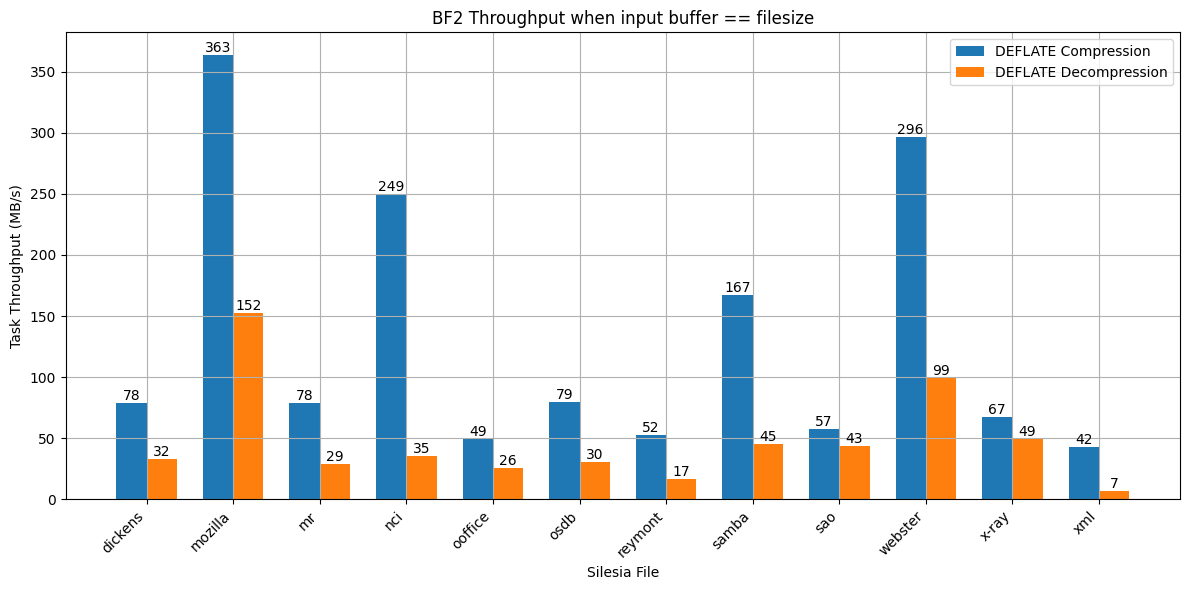

In [58]:

# BF2 DEFLATE Throughput
orig_df = doca_per_device_results['bf2']['dflt'][0]
assert(orig_df.index.name == 'orig')

# Group by 'Configuration' and 'Filename', get the averages across all runs
grouped_df = orig_df.groupby(['Configuration', 'Filename']).mean().reset_index()

# Prepare data for the bar plot
compression_data = grouped_df[grouped_df['Configuration'] == 'CDFLT']
decompression_data = grouped_df[grouped_df['Configuration'] == 'DDFLT']

# Set the position of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(compression_data))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for compression
bars1 = ax.bar(index, compression_data['Task Throughput (MB/s)'], bar_width, label='DEFLATE Compression')

# Bar plot for decompression
bars2 = ax.bar(index + bar_width, decompression_data['Task Throughput (MB/s)'], bar_width, label='DEFLATE Decompression')

# Adding labels and title
ax.set_xlabel('Silesia File')
ax.set_ylabel('Task Throughput (MB/s)')
ax.set_title(f'BF2 Throughput when input buffer == filesize')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(compression_data['Filename'], rotation=45, ha='right')
ax.legend()

# Adding the grid
ax.grid(True)

# Add values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

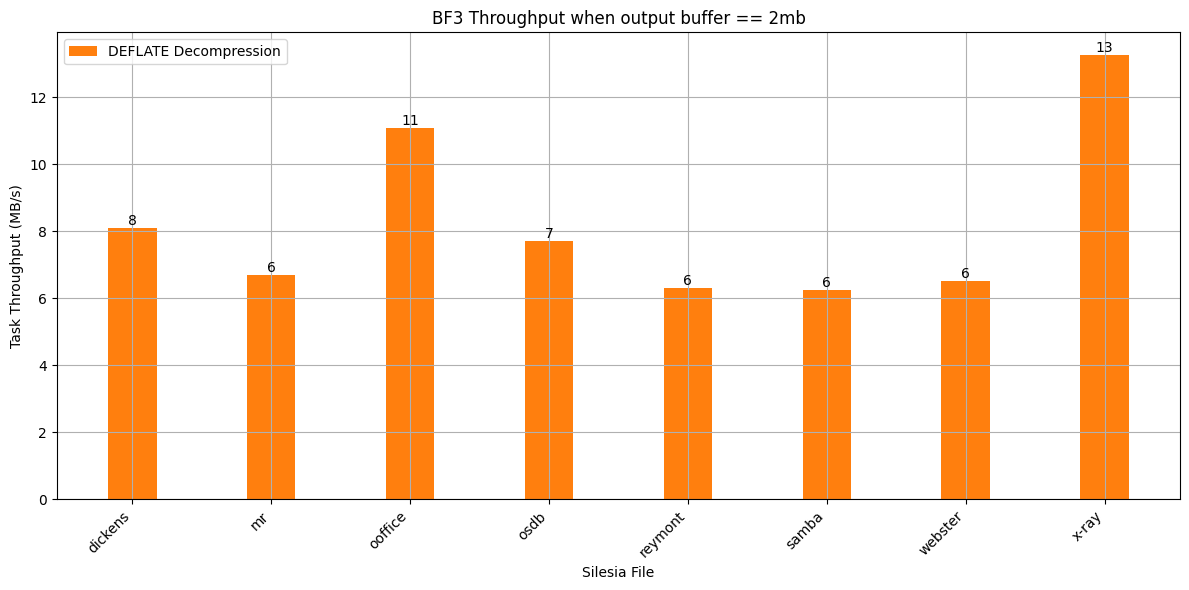

In [59]:
# BF3 DEFLATE Decompression
orig_df = per_device_results['bf3']['dflt'][0]
assert(orig_df.index.name == 'orig')

# Group by 'Configuration' and 'Filename', get the averages across all runs
grouped_df = orig_df.groupby(['Configuration', 'Filename']).mean().reset_index()

# Prepare data for the bar plot
decompression_data = grouped_df[grouped_df['Configuration'] == 'DDFLT']

# Set the position of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(decompression_data))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for decompression
bars = ax.bar(index + bar_width, decompression_data['Task Throughput (MB/s)'], bar_width, label='DEFLATE Decompression', color="tab:orange")

# Adding labels and title
ax.set_xlabel('Silesia File')
ax.set_ylabel('Task Throughput (MB/s)')
ax.set_title(f'BF3 Throughput when output buffer == 2mb')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(decompression_data['Filename'], rotation=45, ha='right')
ax.legend()

# Adding the grid
ax.grid(True)

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

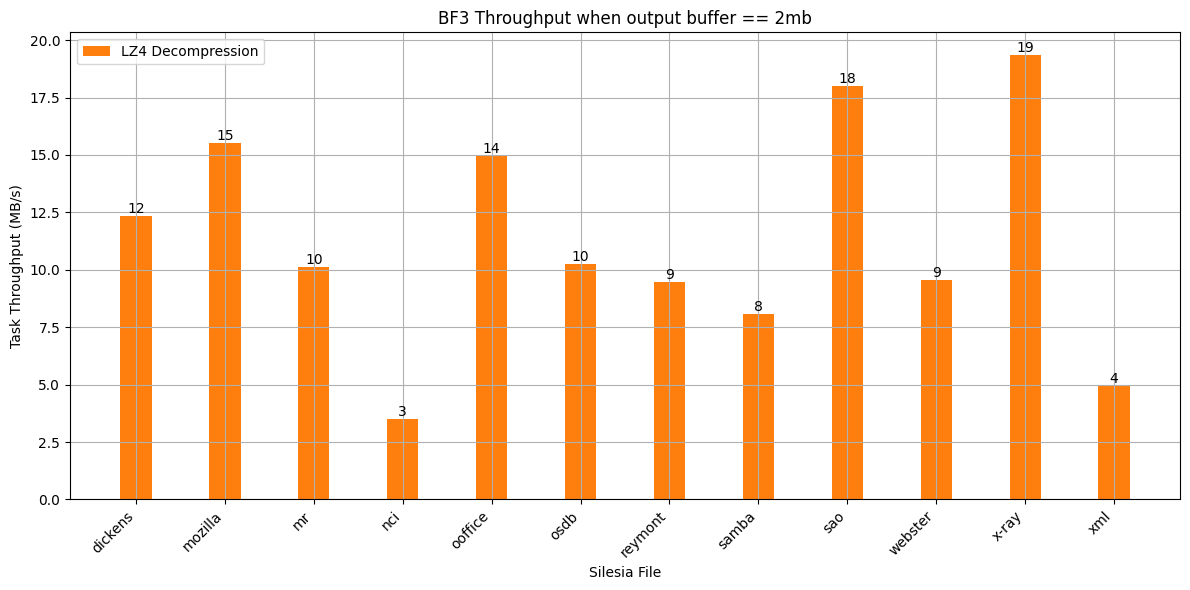

In [55]:
# BF3 LZ4 Decompression
orig_df = per_device_results['bf3']['lz4'][0]
assert(orig_df.index.name == 'orig')

# Group by 'Configuration' and 'Filename', get the averages across all runs
grouped_df = orig_df.groupby(['Configuration', 'Filename']).mean().reset_index()

# Prepare data for the bar plot
decompression_data = grouped_df[grouped_df['Configuration'] == 'DLZ4']

# Set the position of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(decompression_data))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for decompression
bars = ax.bar(index + bar_width, decompression_data['Task Throughput (MB/s)'], bar_width, label='LZ4 Decompression', color="tab:orange")

# Adding labels and title
ax.set_xlabel('Silesia File')
ax.set_ylabel('Task Throughput (MB/s)')
ax.set_title(f'BF3 Throughput when output buffer == 2mb')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(decompression_data['Filename'], rotation=45, ha='right')
ax.legend()

# Adding the grid
ax.grid(True)

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

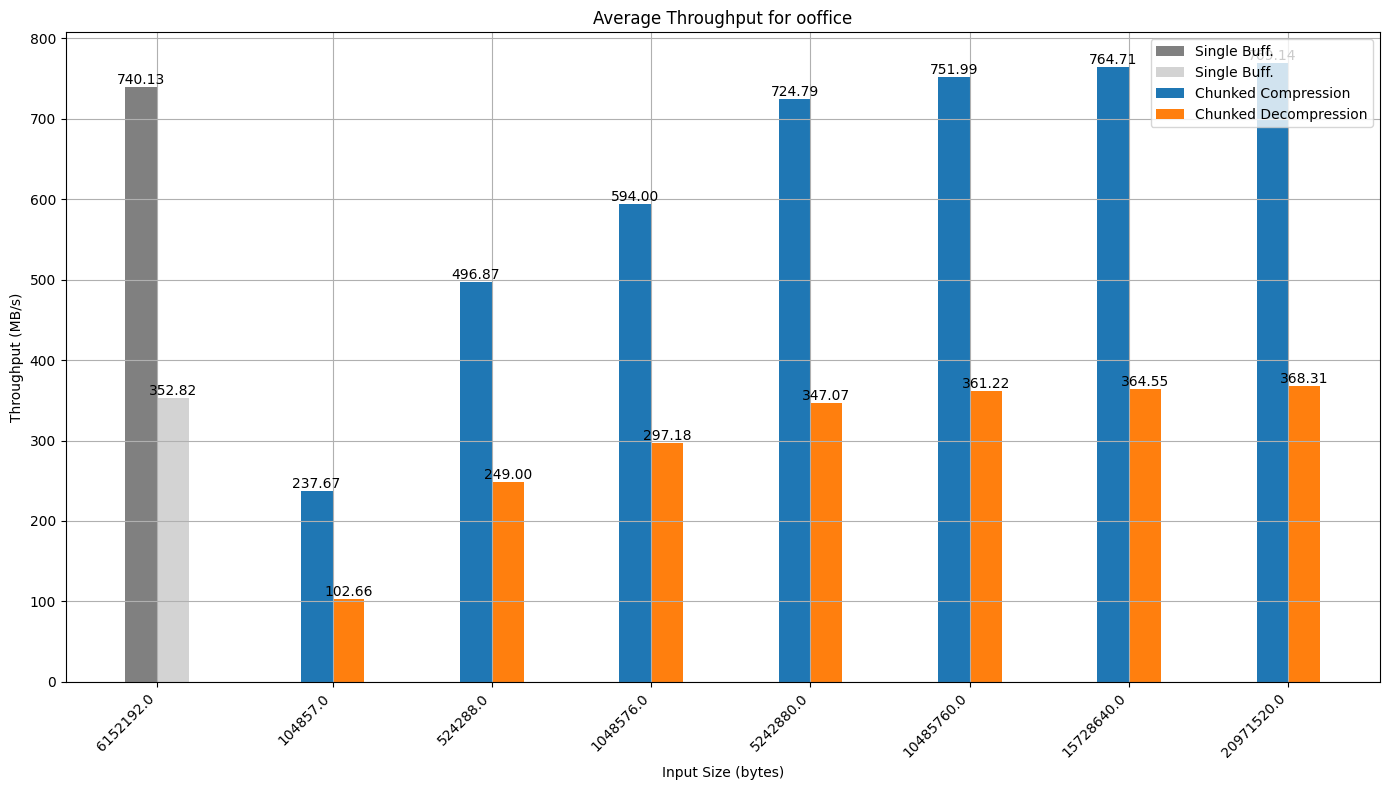

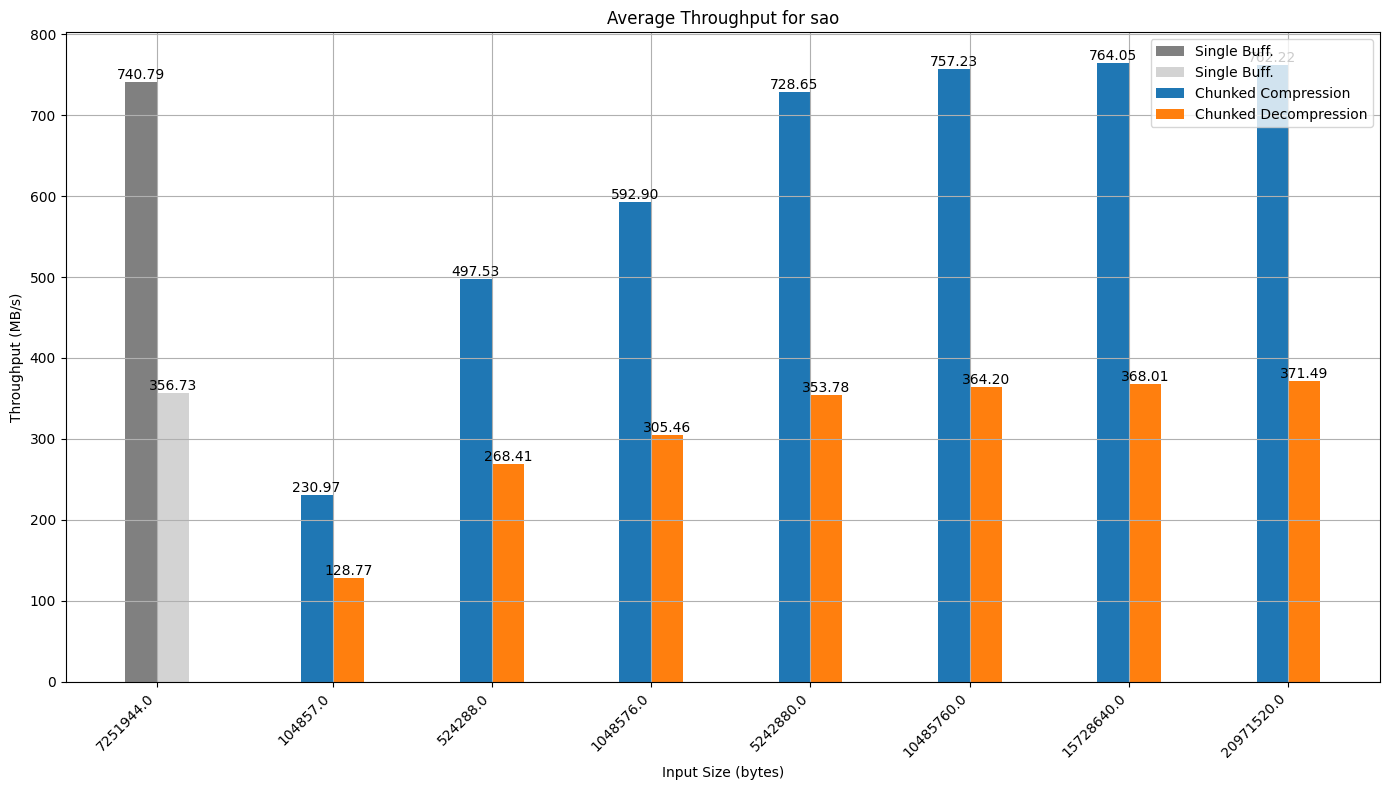

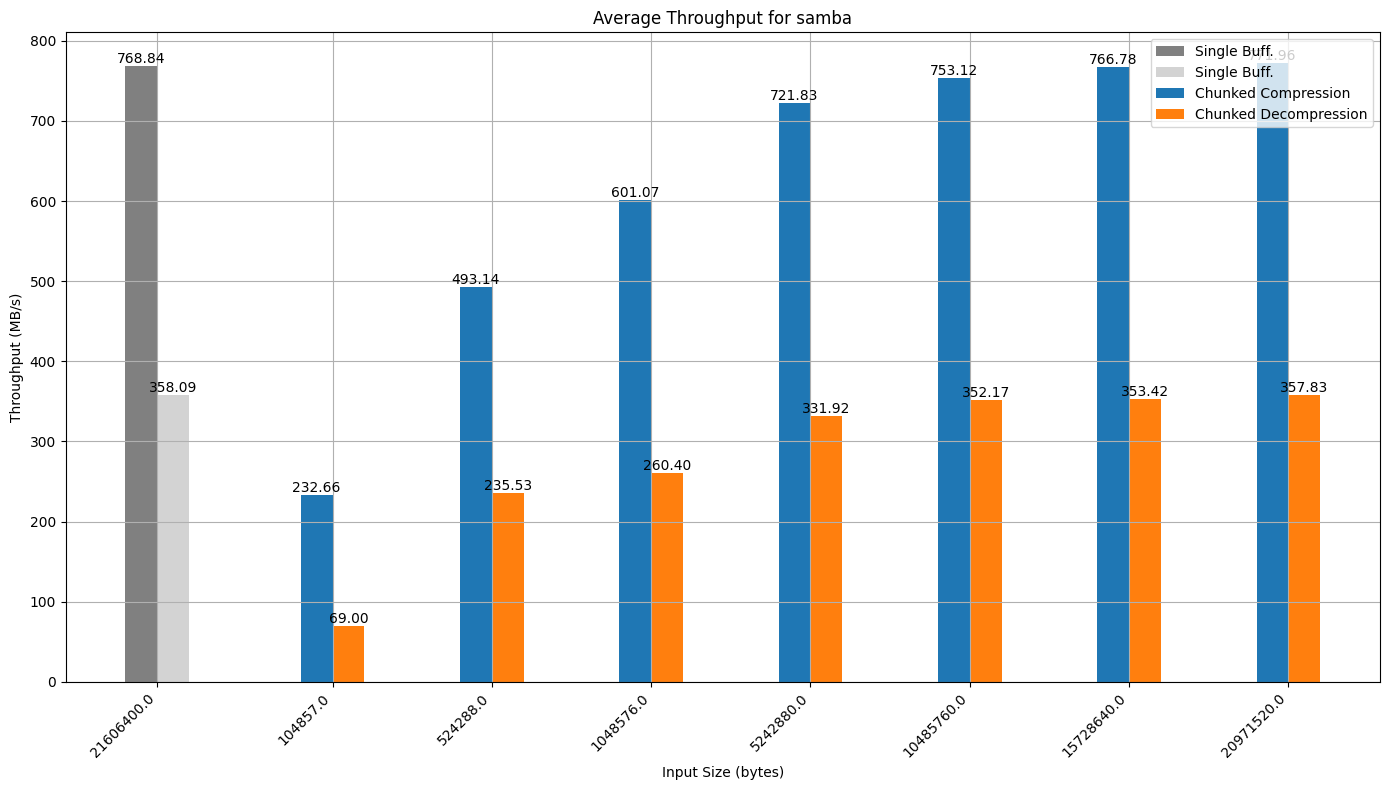

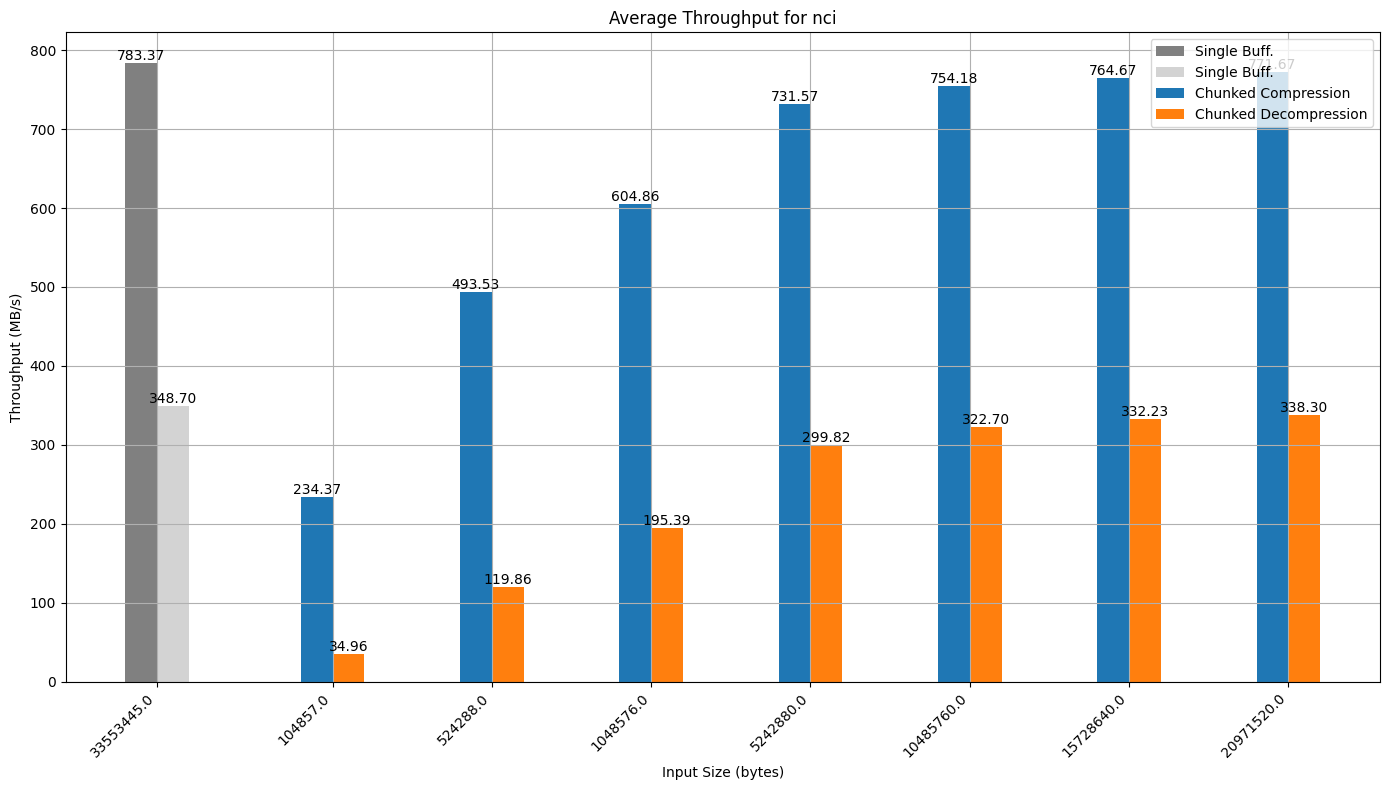

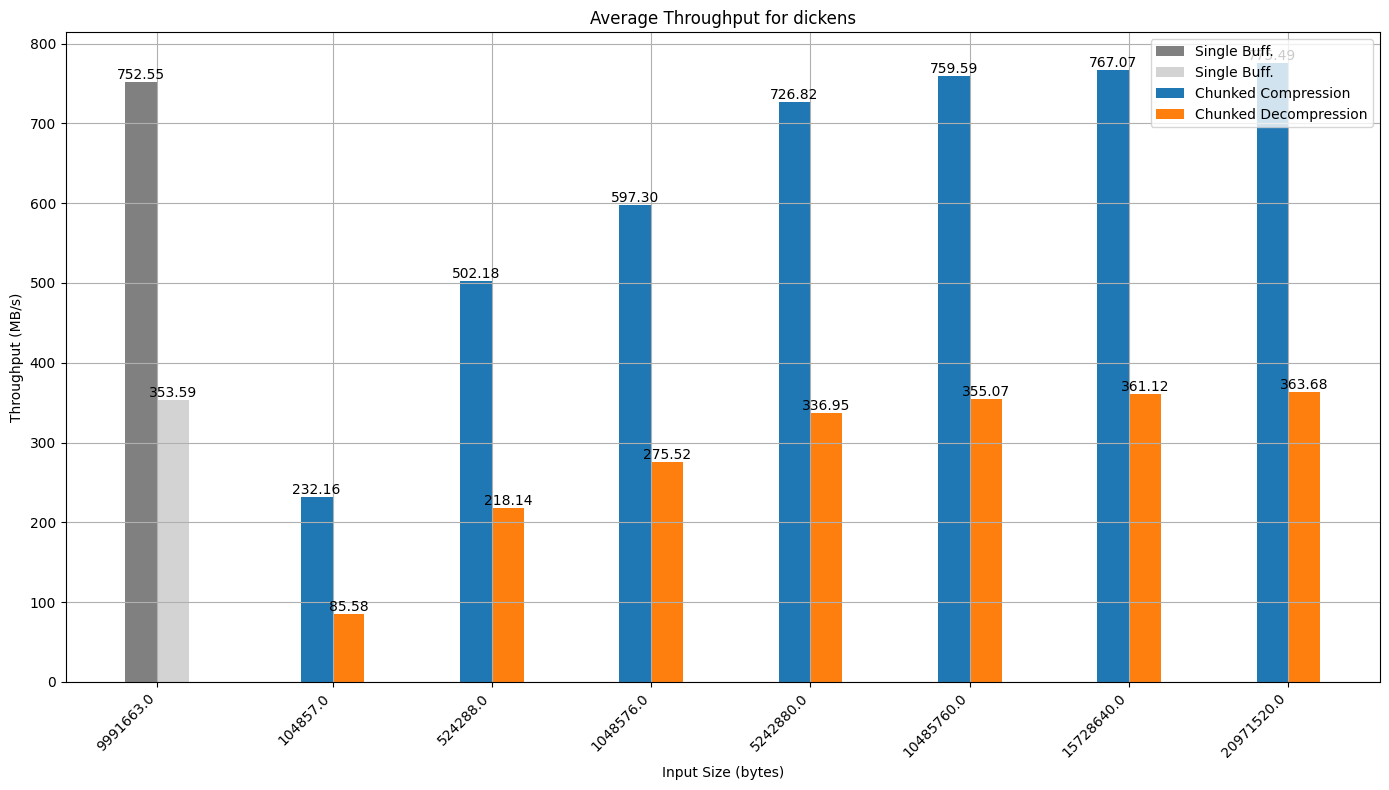

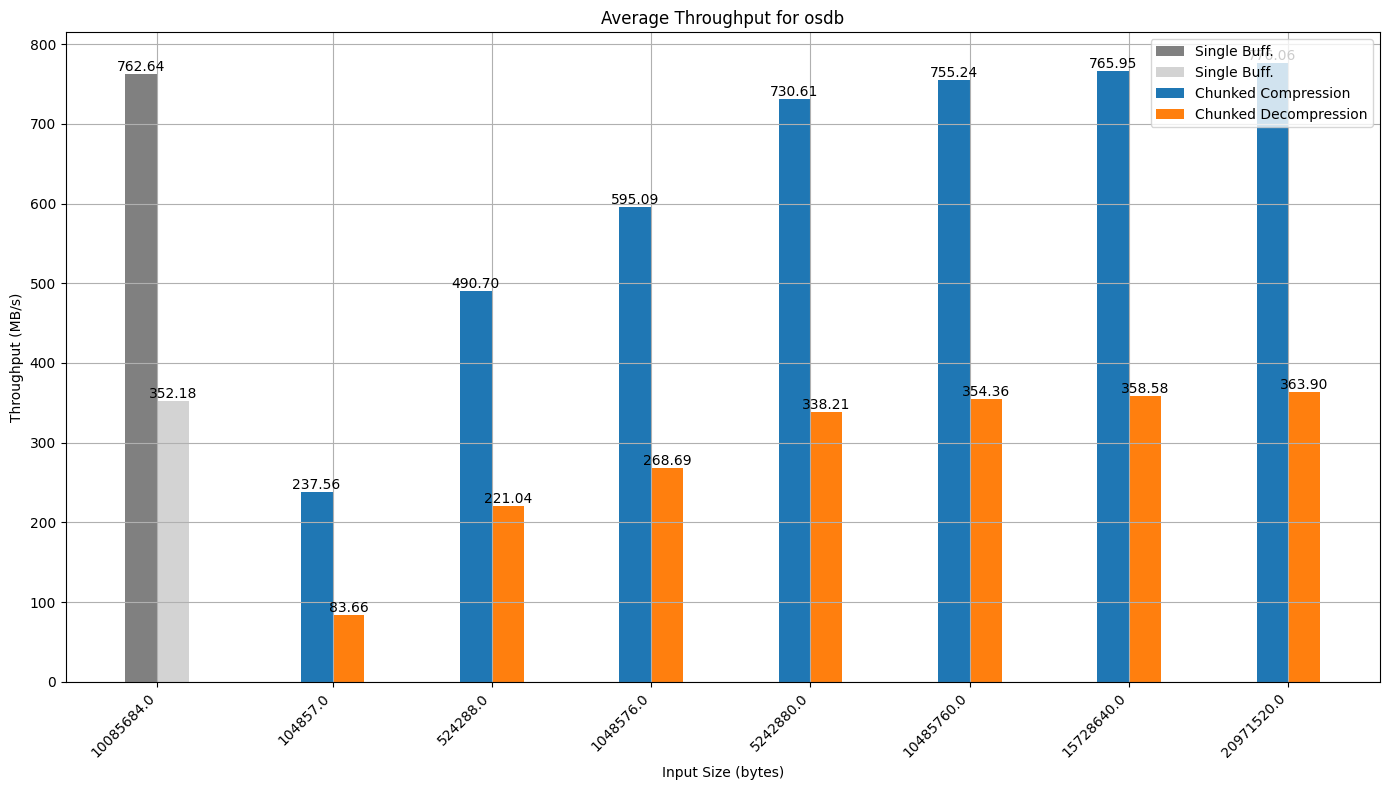

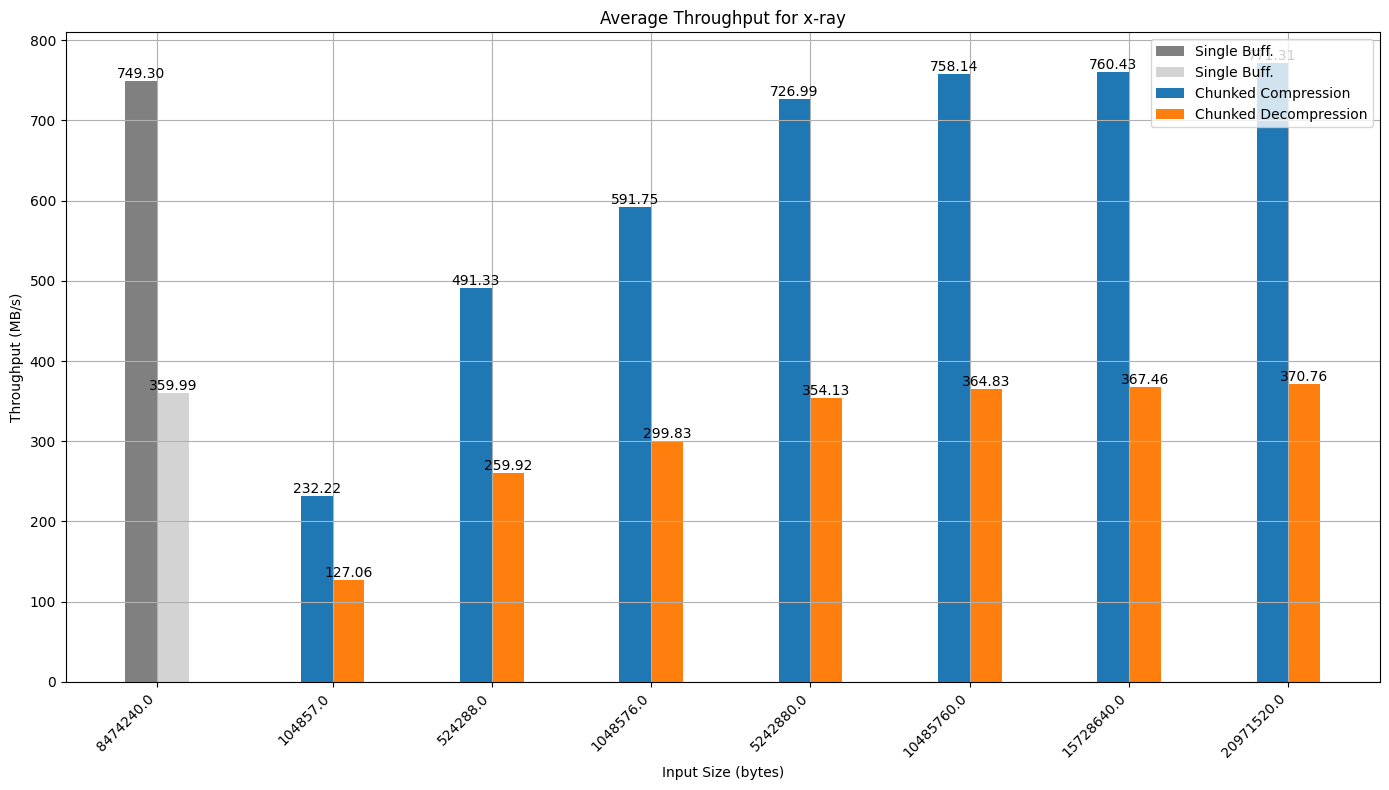

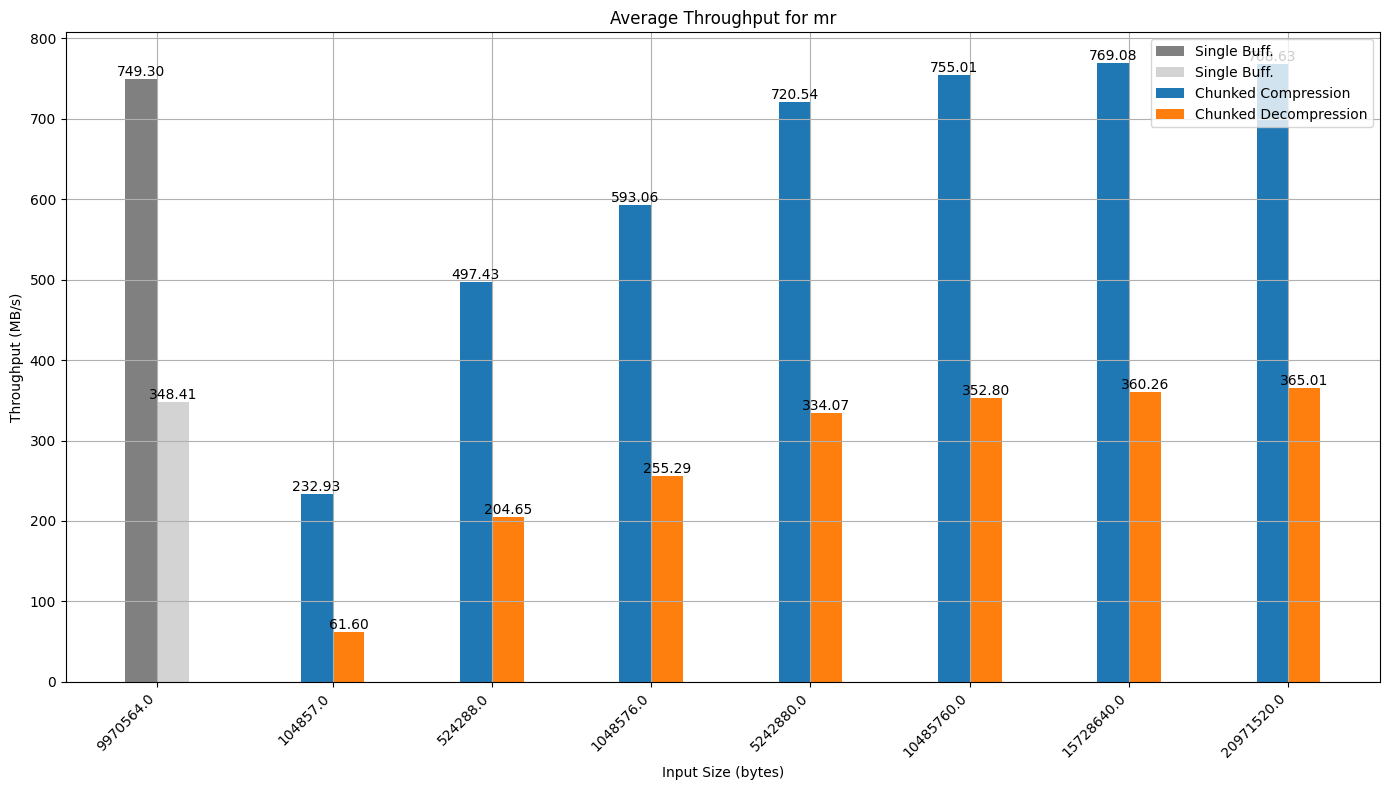

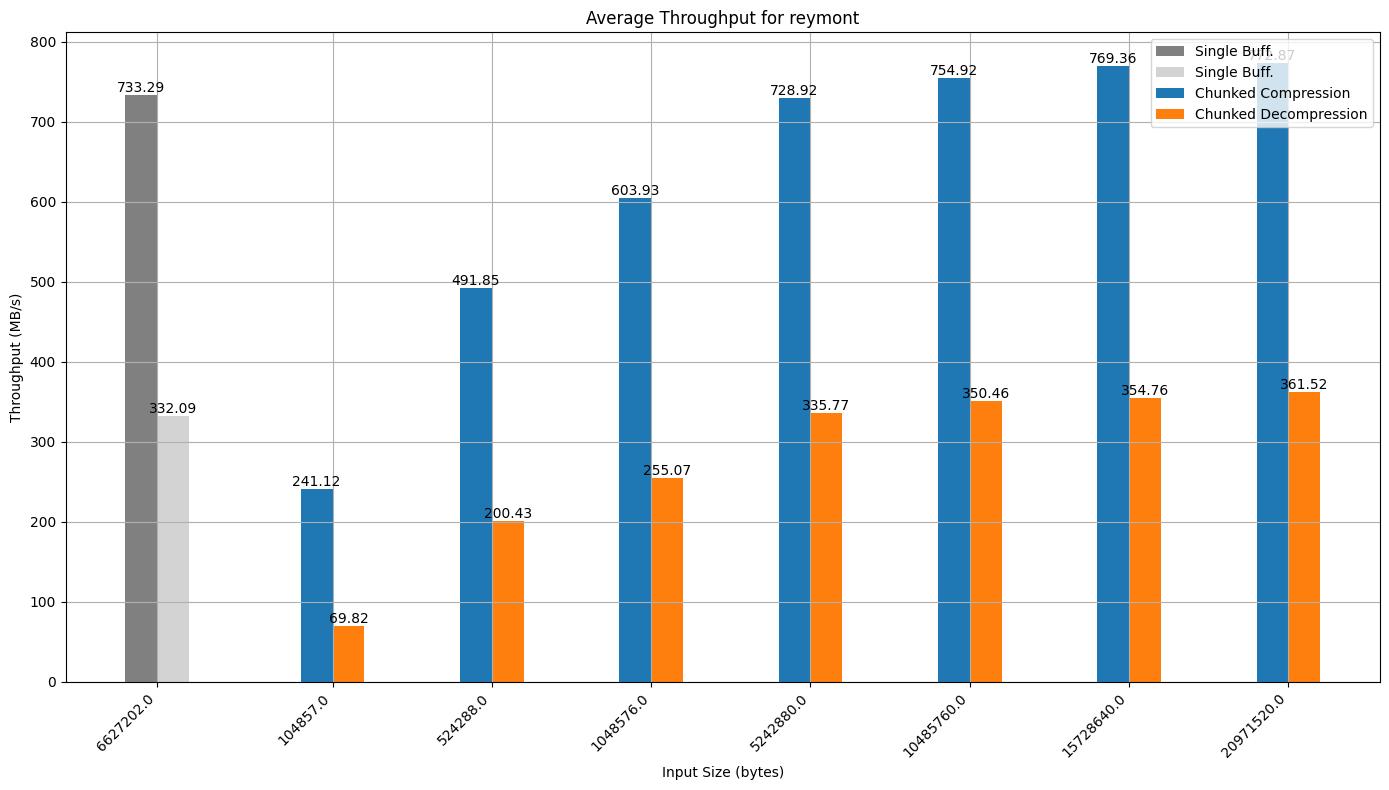

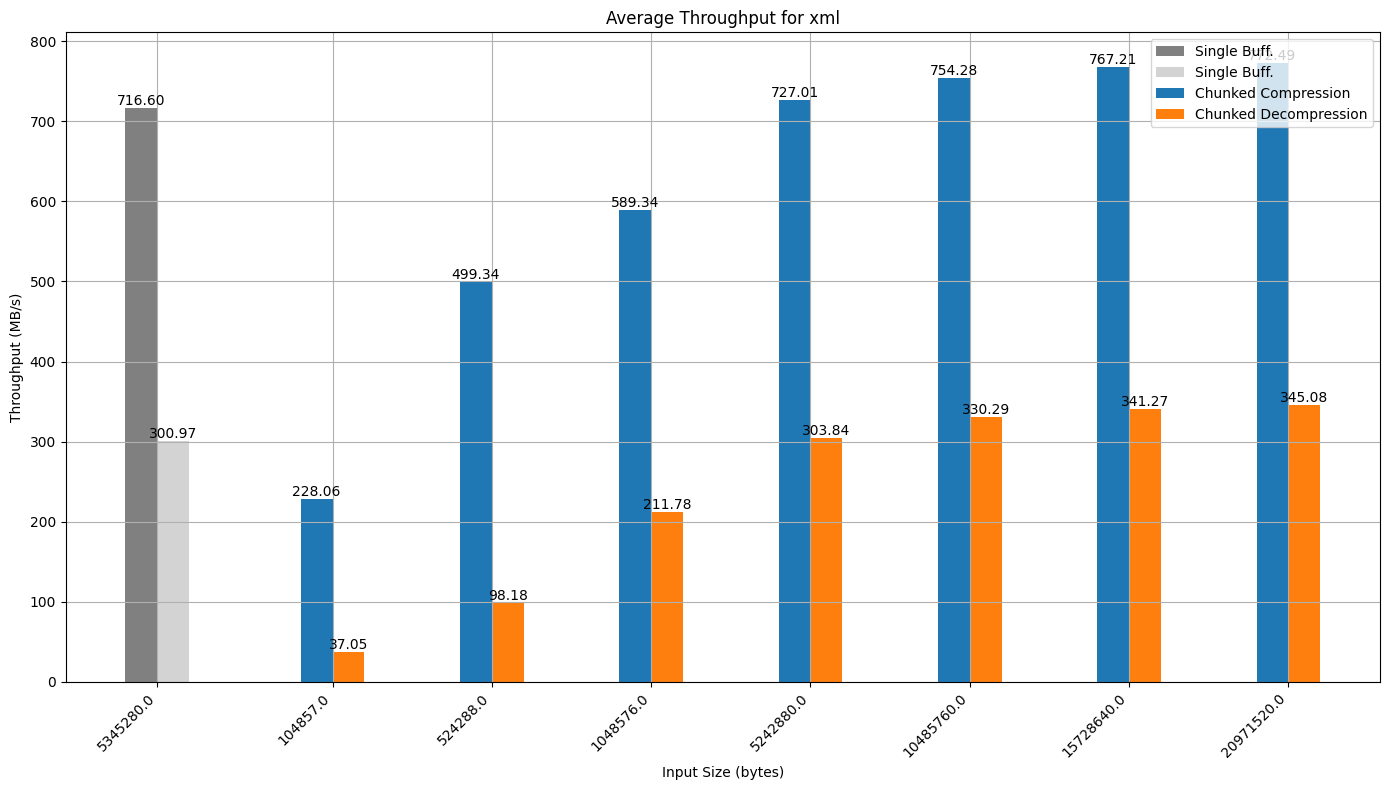

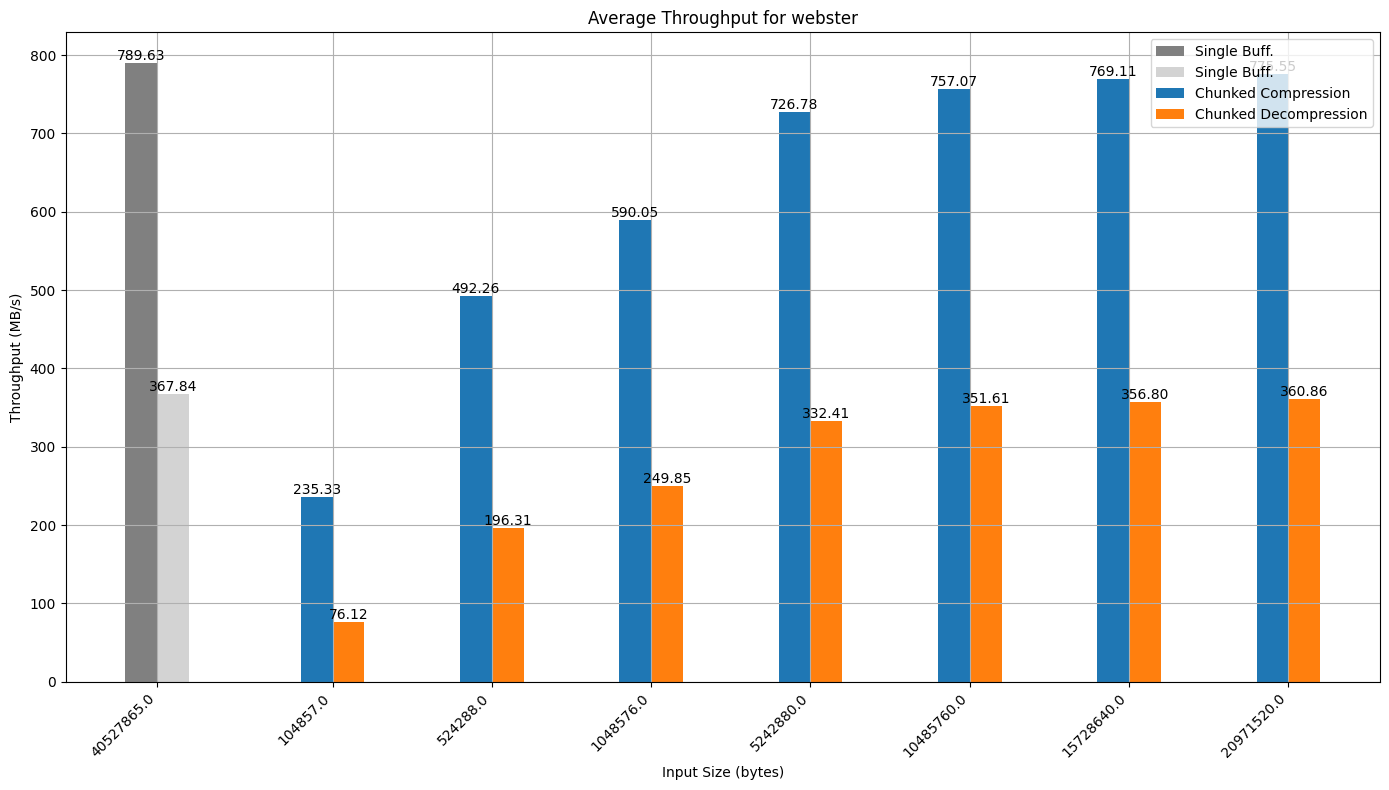

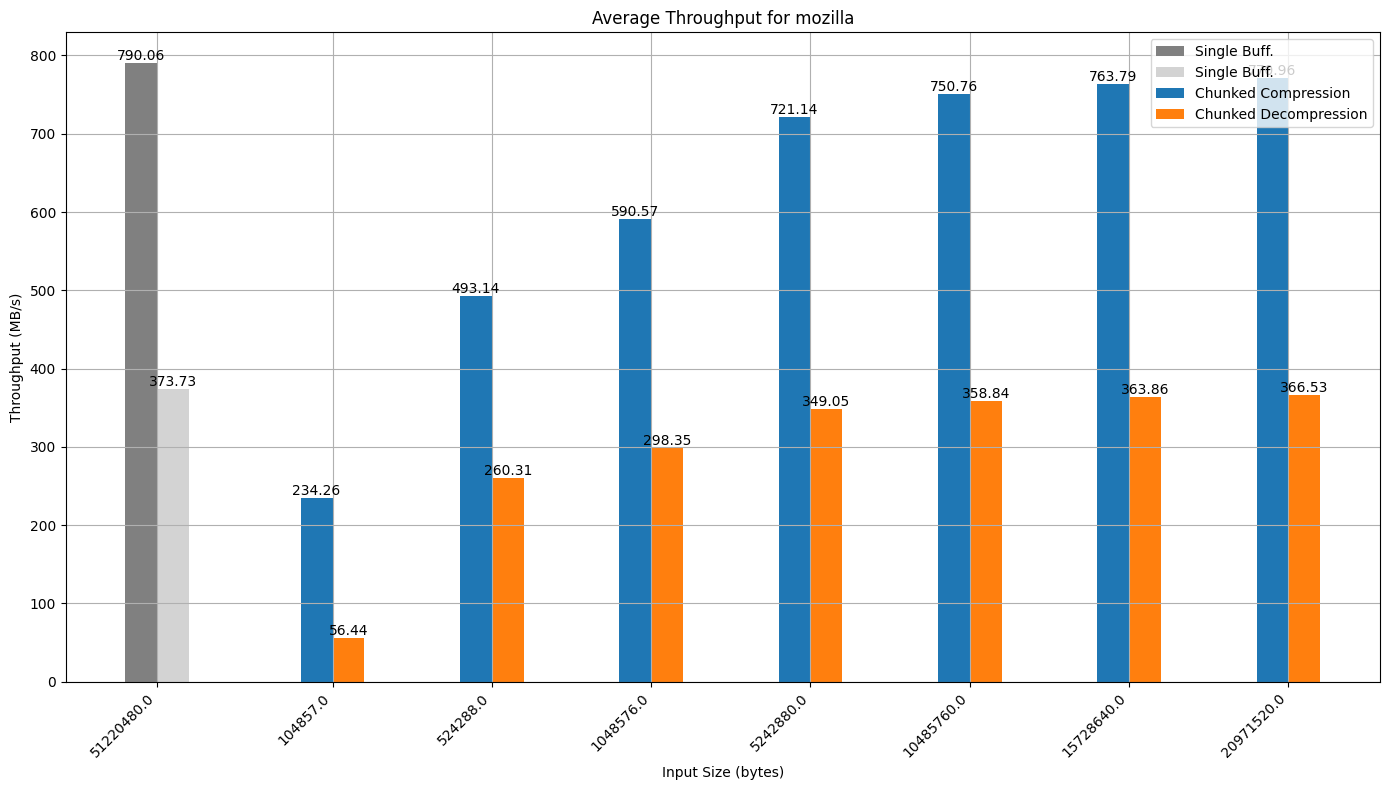

In [4]:
# Get unique filenames
unique_filenames = var_df['Filename'].unique()

# Loop through each unique filename and create a bar plot
for filename in unique_filenames:
    # Filter data for the current filename, both var and orig data
    file_data = var_df[var_df['Filename'] == filename]
    orig_file_data = orig_df[orig_df['Filename'] == filename]
    file_data = file_data.drop(columns=['Filename'])
    orig_file_data = orig_file_data.drop(columns=['Filename'])
    
    # Group by 'Configuration' and 'Input Size (bytes)', get the averages across all runs
    grouped_data = file_data.groupby(['Configuration', 'Input Size (bytes)']).mean().reset_index()

    # Prepare data for the bar plot
    compression_data = grouped_data[grouped_data['Configuration'] == 'CDFLT']
    decompression_data = grouped_data[grouped_data['Configuration'] == 'DDFLT']

    # Match decompression data with compression data by output size
    matched_decompression_data = decompression_data[decompression_data['Input Size (bytes)'].isin(compression_data['Output Size (bytes)'].astype(float))]
    
    # Sort the compression data to ensure correct matching
    compression_data = compression_data.sort_values(by='Input Size (bytes)')
    matched_decompression_data = matched_decompression_data.sort_values(by='Input Size (bytes)')

    # Separate compression and decompression data for orig data
    orig_compression_data = orig_file_data[orig_file_data['Configuration'] == 'CDFLT']
    orig_decompression_data = orig_file_data[orig_file_data['Configuration'] == 'DDFLT']
    
    # Set the position of the bars on the x-axis
    bar_width = 0.2
    index = np.arange(len(compression_data)) + 1  # Shift indices by 1 to make space for orig data
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Bar plot for orig compression
    orig_index = 0
    orig_bars1 = ax.bar(orig_index - bar_width/2, orig_compression_data['Throughput (MB/s)'].mean(), bar_width, label='Single Buff.', color='gray')
    
    # Bar plot for orig decompression
    orig_bars2 = ax.bar(orig_index + bar_width/2, orig_decompression_data['Throughput (MB/s)'].mean(), bar_width, label='Single Buff.', color='lightgray')
    
    # Bar plot for compression
    bars1 = ax.bar(index, compression_data['Throughput (MB/s)'], bar_width, label='Chunked Compression')
    
    # Bar plot for matched decompression
    bars2 = ax.bar(index + bar_width, matched_decompression_data['Throughput (MB/s)'], bar_width, label='Chunked Decompression')
    
    # Adding labels and title
    ax.set_xlabel('Input Size (bytes)')
    ax.set_ylabel('Throughput (MB/s)')
    ax.set_title(f'Average Throughput for {filename}')
    ax.set_xticks(np.append(orig_index, index + bar_width / 2))
    ax.set_xticklabels(np.append(orig_compression_data['Input Size (bytes)'].mean(), compression_data['Input Size (bytes)']), rotation=45, ha='right')
    ax.legend()
    
    # Adding the grid
    ax.grid(True)
    
    # Add values on top of the bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    
    # Add values on top of the orig bars
    orig_compression_height = orig_compression_data['Throughput (MB/s)'].mean()
    ax.text(orig_bars1[0].get_x() + orig_bars1[0].get_width() / 2.0, orig_compression_height, f'{orig_compression_height:.2f}', ha='center', va='bottom')
    
    orig_decompression_height = orig_decompression_data['Throughput (MB/s)'].mean()
    ax.text(orig_bars2[0].get_x() + orig_bars2[0].get_width() / 2.0, orig_decompression_height, f'{orig_decompression_height:.2f}', ha='center', va='bottom')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

Figure saved to ../../tex/figures/za-evaluation/de_compression_var_file.png


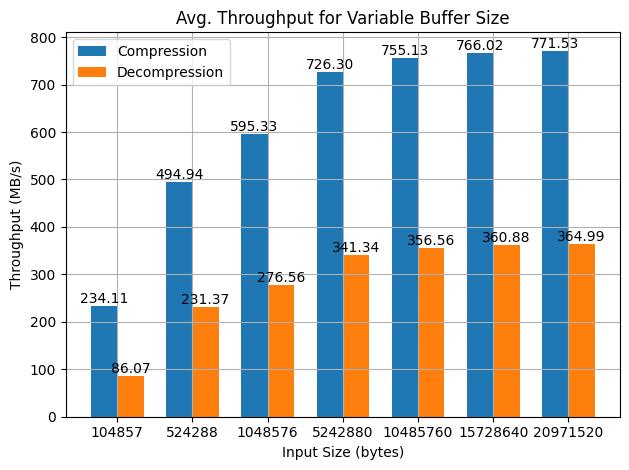

In [47]:
# Group by 'Configuration' and 'Filename', get the averages across all runs
file_data = var_df.drop(columns=['Filename', 'Time Taken (seconds)', 'Dest. DOCA Buffer (bytes)'])

# Drop unnecessary data
compression_data = file_data[file_data['Configuration'] == 'CDFLT']
compression_data = compression_data.drop(columns=['Configuration', 'Output Size (bytes)'])
decompression_data = file_data[file_data['Configuration'] == 'DDFLT']
decompression_data = decompression_data.drop(columns=['Configuration', 'Input Size (bytes)'])

# Drop errors in decompression (result is not calculated properly)
decompression_data = decompression_data[decompression_data['Output Size (bytes)'] != 4294967295]

# Get averages after group-by
compression_data = compression_data.groupby(['Input Size (bytes)']).mean().reset_index()
decompression_data = decompression_data.groupby(['Output Size (bytes)']).mean().reset_index()

# Plotting
bar_width = 0.35
index = np.arange(len(compression_data))  # the x locations for the groups

# Create figure and axes
fig, ax = plt.subplots()

# Plot compression data as bars
bars1 = ax.bar(index, compression_data['Throughput (MB/s)'], bar_width, label='Compression')

# Plot decompression data as bars next to compression
bars2 = ax.bar(index + bar_width, decompression_data['Throughput (MB/s)'], bar_width, label='Decompression')

# Add labels on top of each bar
for bar1, bar2 in zip(bars1, bars2):
    ax.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(), 
            f'{bar1.get_height():.2f}', ha='center', va='bottom', rotation=0)
    ax.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(), 
            f'{bar2.get_height():.2f}', ha='center', va='bottom', rotation=0)

# Add labels, title, and legend
ax.set_xlabel('Input Size (bytes)')
ax.set_ylabel('Throughput (MB/s)')
ax.set_title('Avg. Throughput for Variable Buffer Size')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(compression_data['Input Size (bytes)'])  # Assuming sizes are the same for compression and decompression

ax.legend()

# Adding the grid
ax.grid(True)

plt.tight_layout()

# Save the figure
save_figure(fig, "de_compression_var_file.png")

plt.show()

In [9]:
# Use glob to find the 'orig' CSV file in the latest directory
orig_cpu_csv_path = glob.glob(f'{latest_dir}cpu/*orig*.csv')[0]

# Load the CSV file into a DataFrame
orig_cpu_df = pd.read_csv(orig_cpu_csv_path, delim_whitespace=True)

# Use glob to find the 'orig' CSV file in the latest directory
var_cpu_csv_path = glob.glob(f'{latest_dir}cpu/*variable*.csv')[0]

# Load the CSV file into a DataFrame
var_cpu_df = pd.read_csv(var_cpu_csv_path, delim_whitespace=True)

# Drop the 'Dataset' column since we are focusing on a single dataset for now
orig_cpu_df = orig_cpu_df.drop(columns=['codec', 'level', 'param', 'cmem', 'dmem', 'cstack', 'dstack', 'time'])
var_cpu_df = var_cpu_df.drop(columns=['codec', 'level', 'param', 'cmem', 'dmem', 'cstack', 'dstack', 'time'])

Figure saved to ../../tex/figures/za-evaluation/de_compression_cpu.png


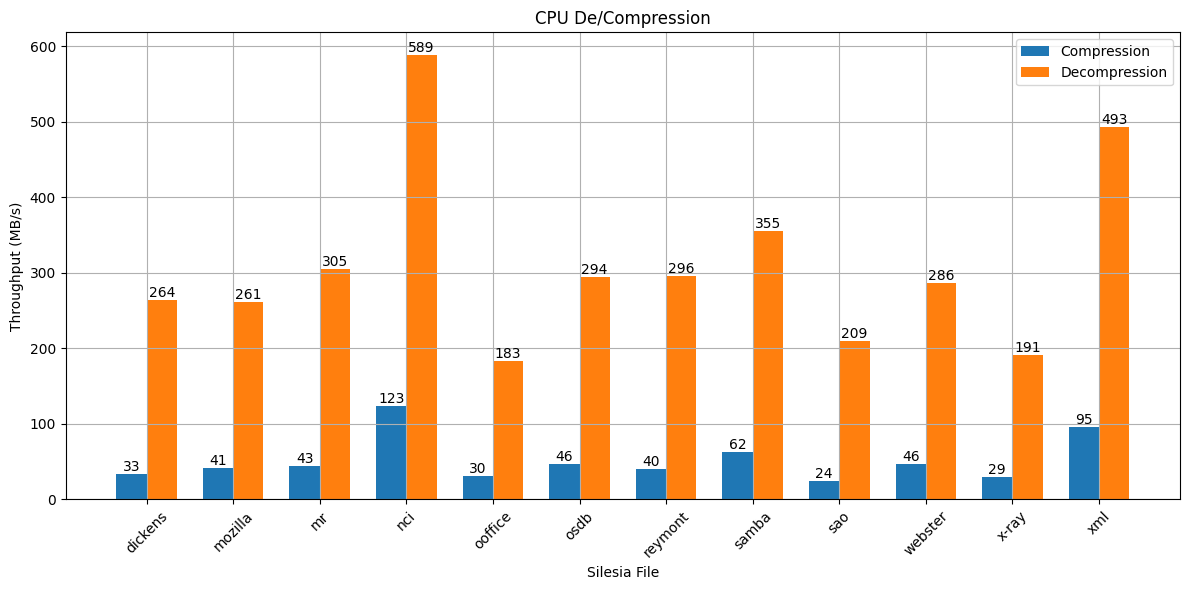

In [10]:
# Calculate megabytes per second
orig_cpu_df['d_mb_per_s'] = orig_cpu_df['size'] / (orig_cpu_df['dtime'] * 1024 * 1024)
orig_cpu_df['c_mb_per_s'] = orig_cpu_df['size'] / (orig_cpu_df['ctime'] * 1024 * 1024)

# Create a long-form DataFrame for plotting
data_long = pd.melt(orig_cpu_df, id_vars=['dataset'], value_vars=['c_mb_per_s', 'd_mb_per_s'],
                    var_name='Type', value_name='MB_per_s')

# Map the compression and decompression labels to be more descriptive
data_long['Type'] = data_long['Type'].map({'c_mb_per_s': 'Compression', 'd_mb_per_s': 'Decompression'})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot
datasets = orig_cpu_df['dataset'].unique()
x = np.arange(len(datasets))  # the label locations
width = 0.35  # the width of the bars

# Separate data for compression and decompression
compression_data = data_long[data_long['Type'] == 'Compression']
decompression_data = data_long[data_long['Type'] == 'Decompression']

# Create bar plots
bar1 = ax.bar(x - width/2, compression_data['MB_per_s'], width, label='Compression')
bar2 = ax.bar(x + width/2, decompression_data['MB_per_s'], width, label='Decompression')

# Adding the grid
ax.grid(True)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Silesia File')
ax.set_ylabel('Throughput (MB/s)')
ax.set_title('CPU De/Compression')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()

# Add values on top of the bars
for bar in bar1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

# Tighten the plot
plt.tight_layout()

# Save the figure
save_figure(fig, "de_compression_cpu.png")

# Show the plot
plt.show()

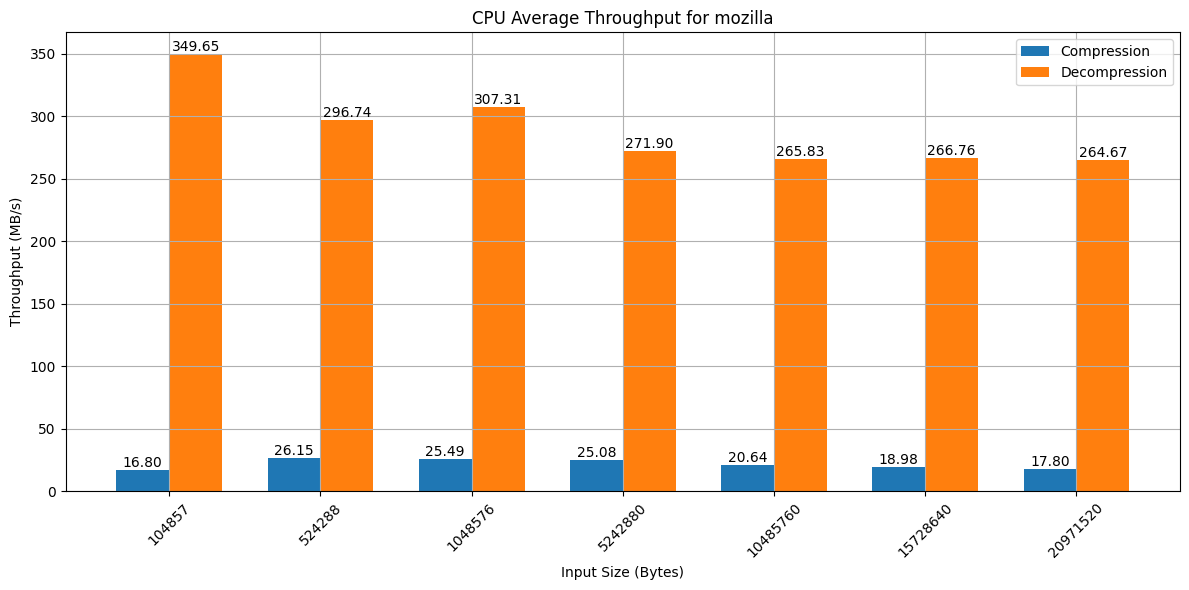

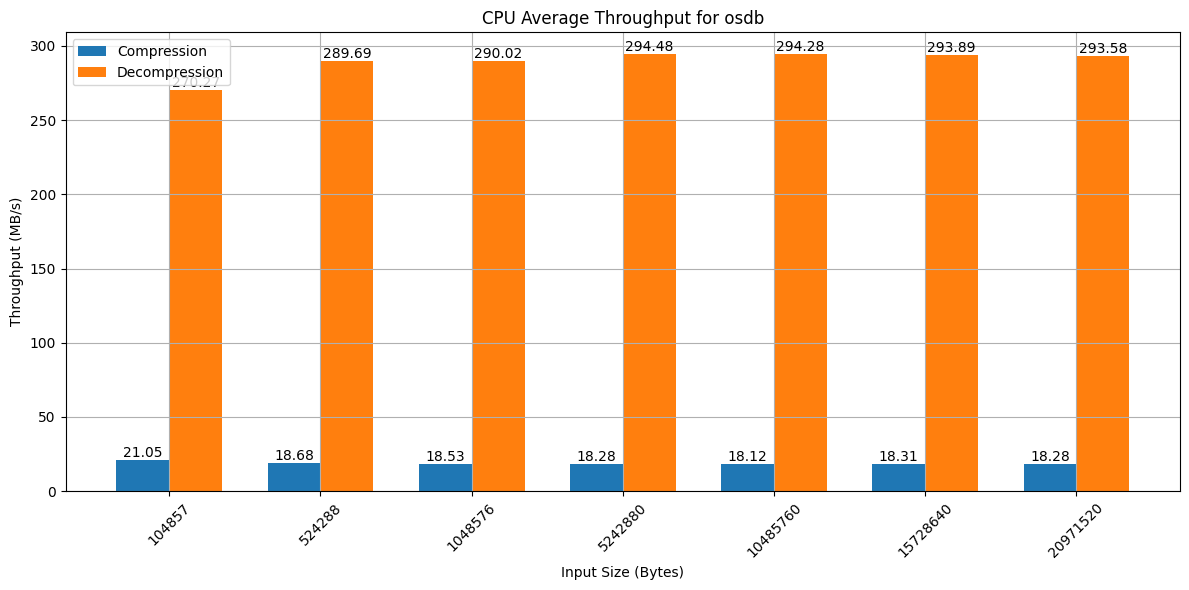

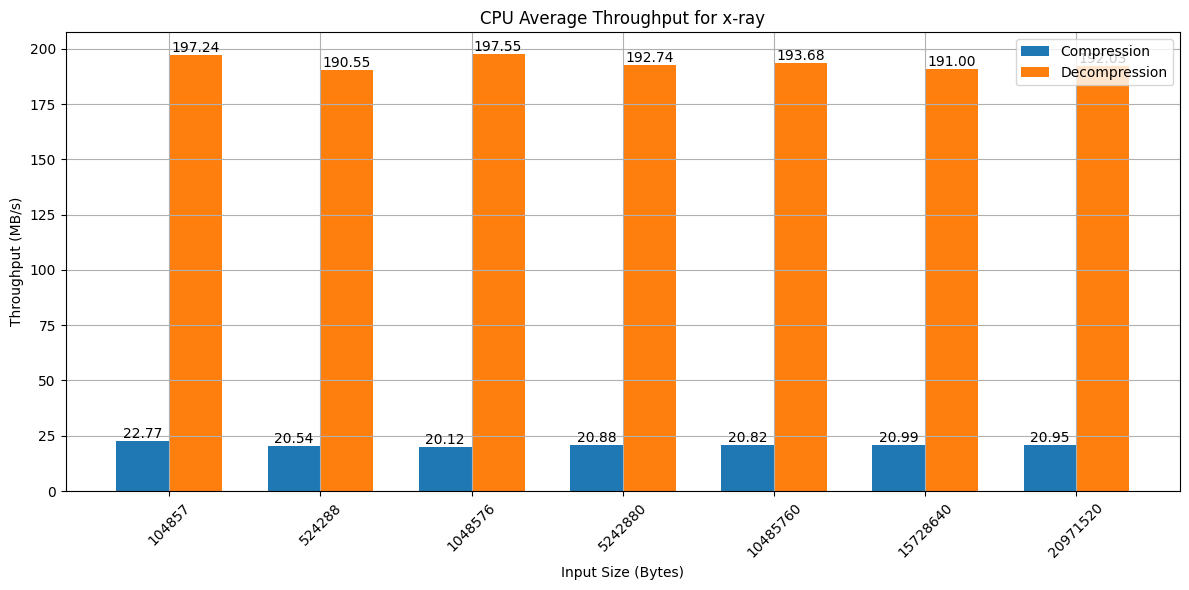

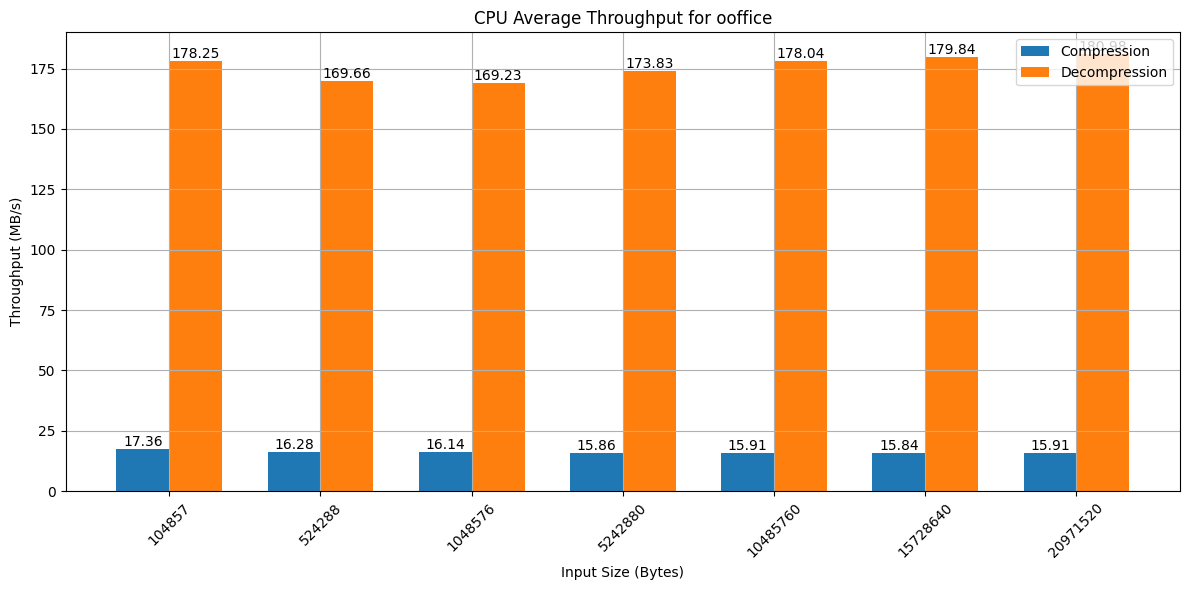

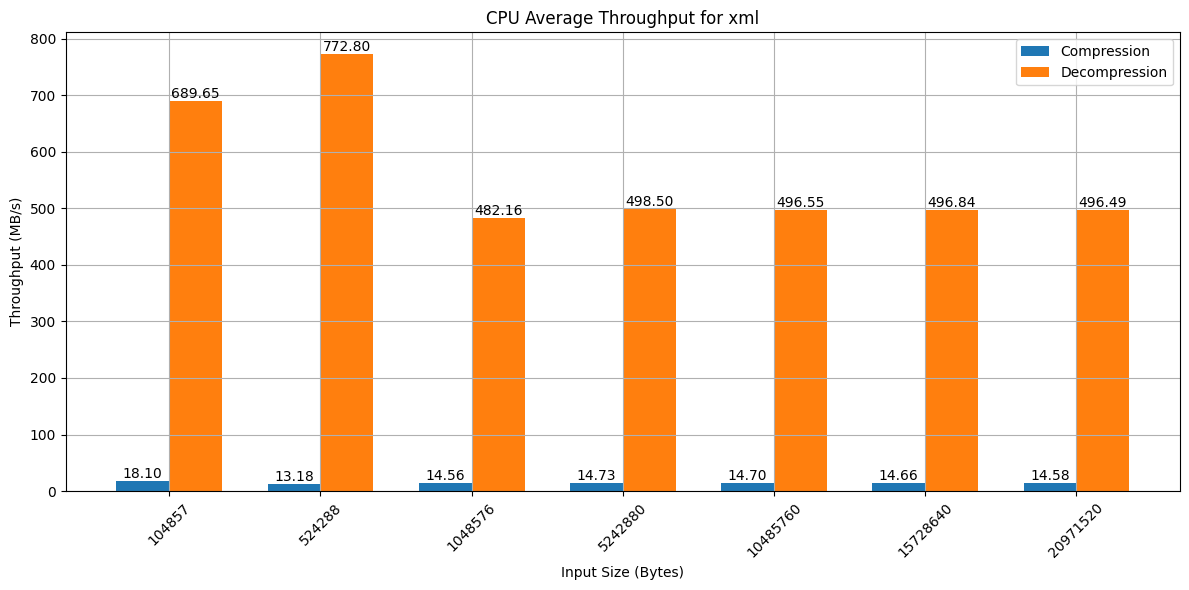

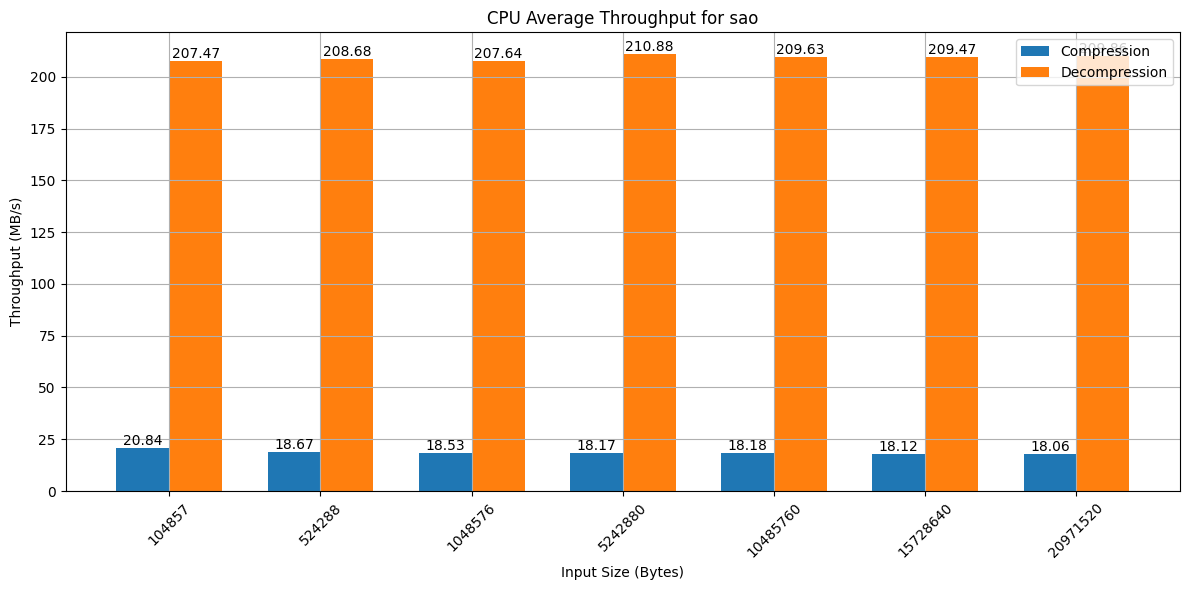

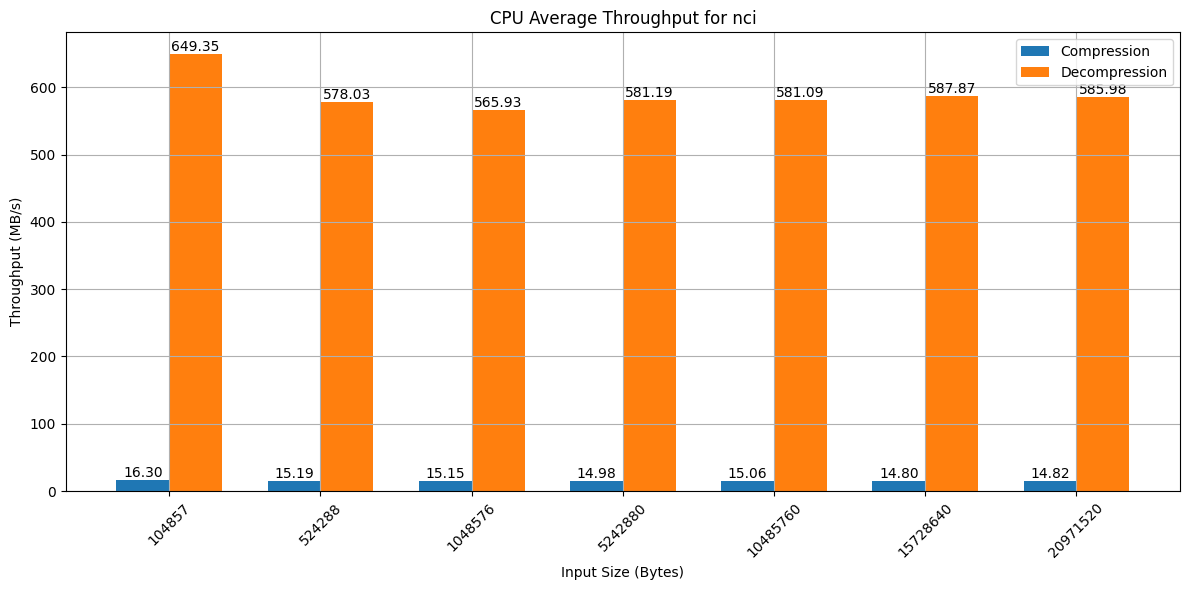

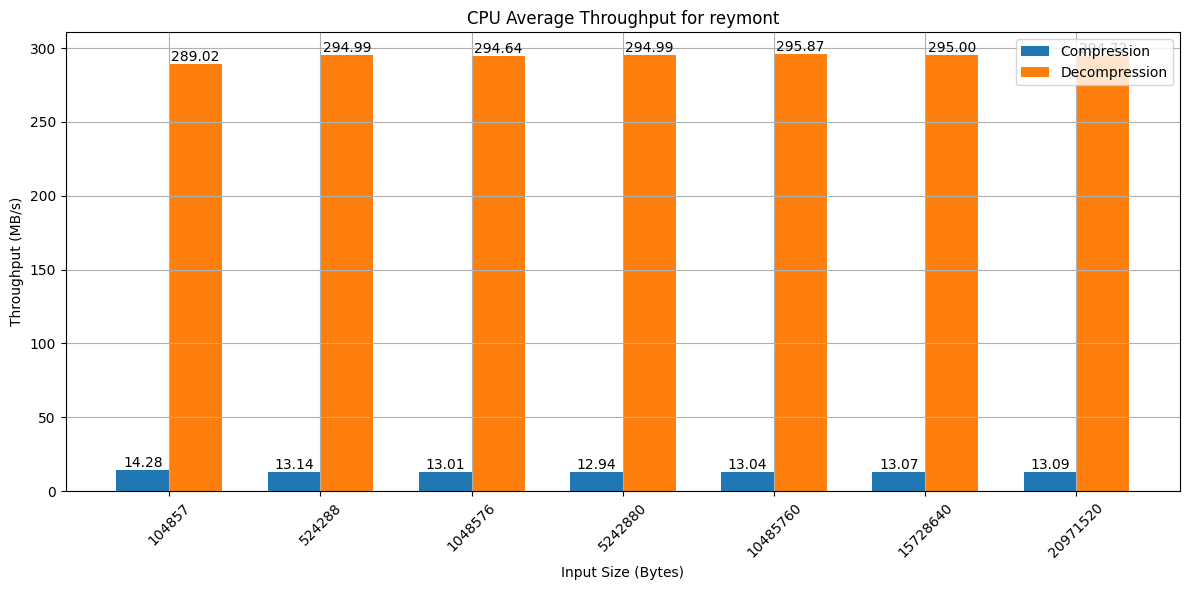

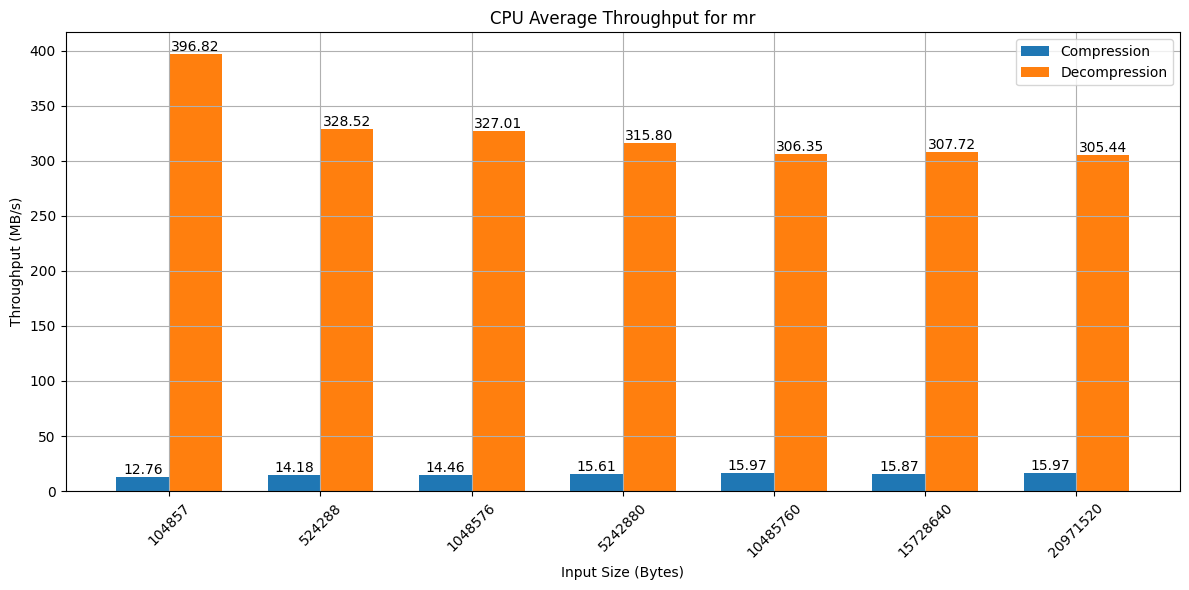

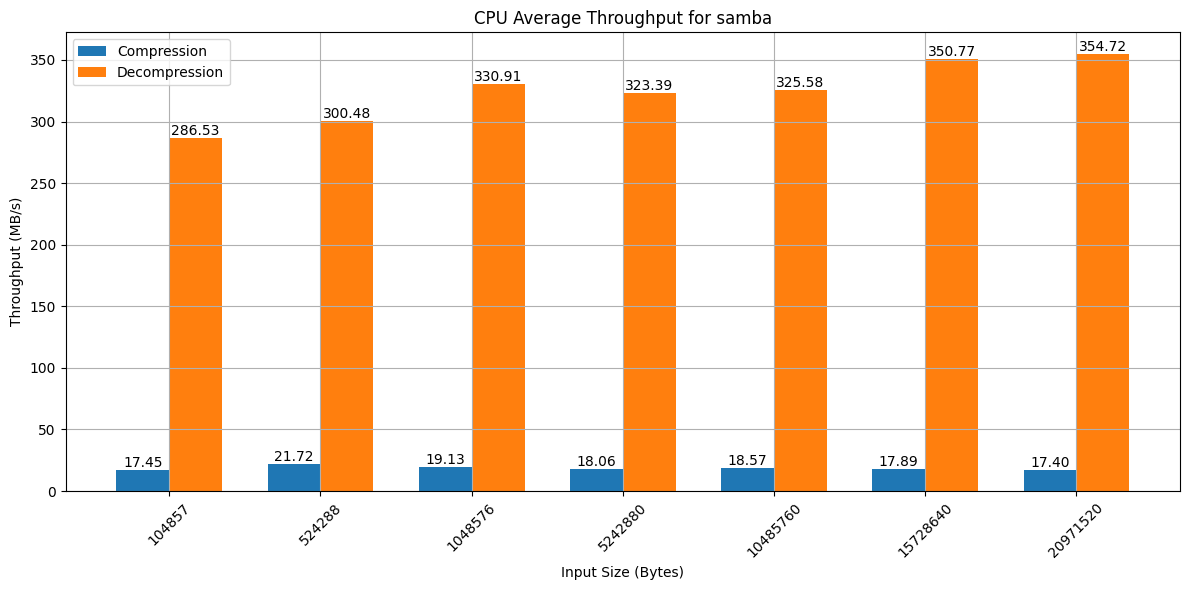

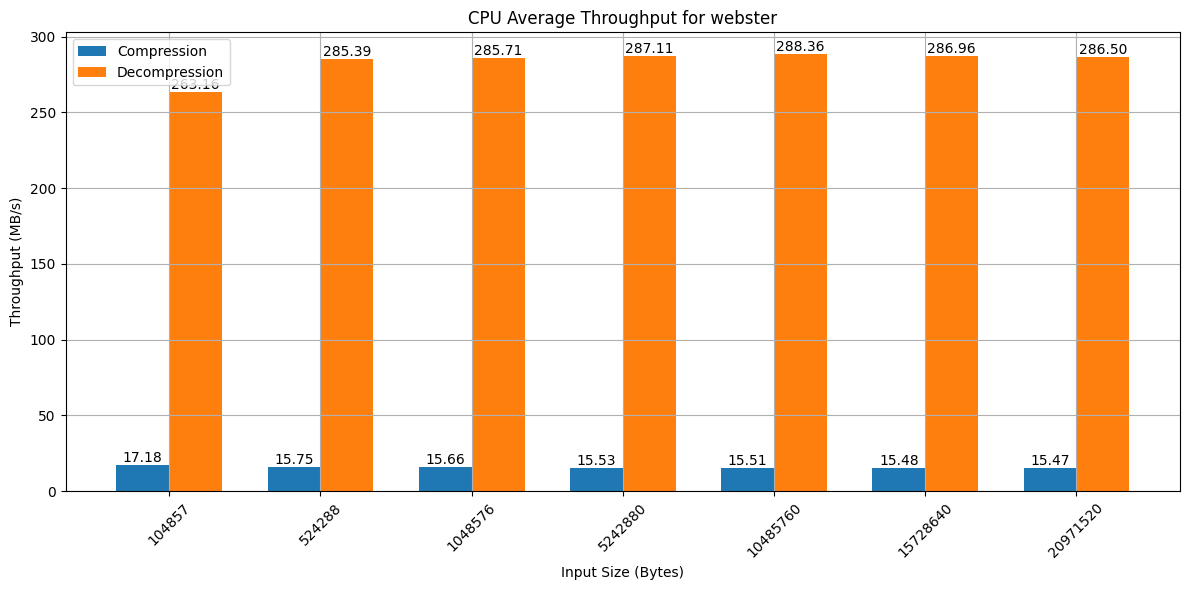

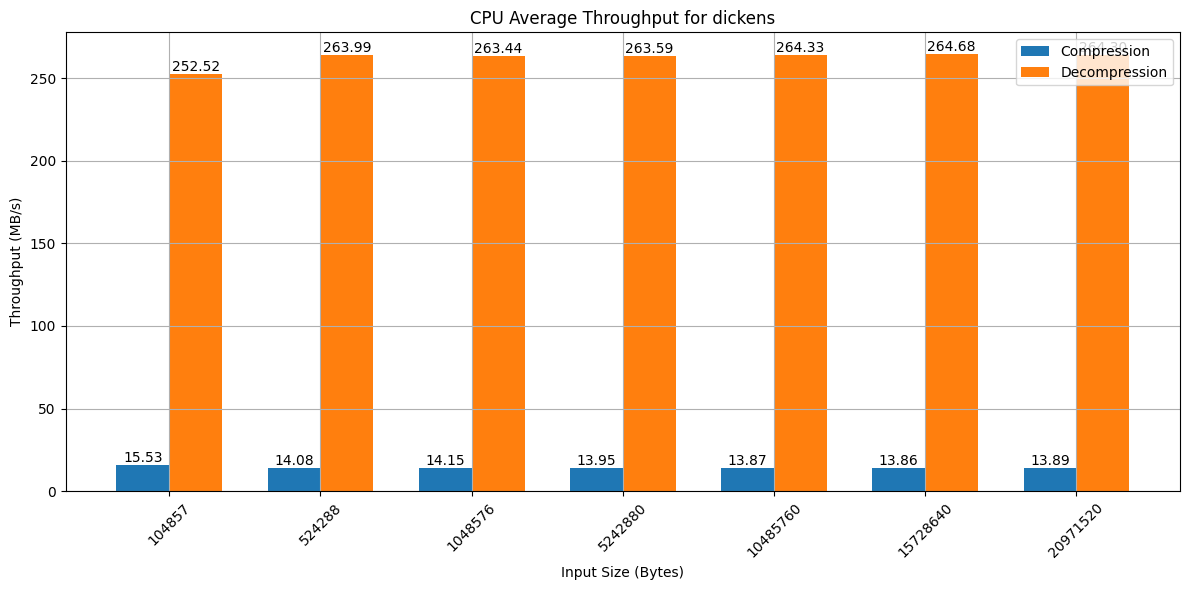

In [39]:
# Calculate megabytes per second
var_cpu_df['c_mb_per_s'] = var_cpu_df['csize'] / (var_cpu_df['ctime'] * 1024 * 1024)
var_cpu_df['d_mb_per_s'] = var_cpu_df['size'] / (var_cpu_df['dtime'] * 1024 * 1024)

# Create a long-form DataFrame for plotting
data_long = pd.melt(var_cpu_df, id_vars=['dataset', 'size'], value_vars=['c_mb_per_s', 'd_mb_per_s'],
                    var_name='Type', value_name='MB_per_s')

# Map the compression and decompression labels to be more descriptive
data_long['Type'] = data_long['Type'].map({'c_mb_per_s': 'Compression', 'd_mb_per_s': 'Decompression'})

# Get unique datasets
datasets = var_cpu_df['dataset'].unique()

# Create a plot for each dataset
for dataset in datasets:
    dataset_data = data_long[data_long['dataset'] == dataset]
    
    # Sort the data by size
    dataset_data = dataset_data.sort_values(by='size')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot data for compression and decompression
    x = np.arange(len(dataset_data['size'].unique()))  # the label locations
    width = 0.35  # the width of the bars
    
    compression_data = dataset_data[dataset_data['Type'] == 'Compression']
    decompression_data = dataset_data[dataset_data['Type'] == 'Decompression']
    
    bar1 = ax.bar(x - width/2, compression_data['MB_per_s'], width, label='Compression')
    bar2 = ax.bar(x + width/2, decompression_data['MB_per_s'], width, label='Decompression')

    # Adding the grid
    ax.grid(True)
    
    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Input Size (Bytes)')
    ax.set_ylabel('Throughput (MB/s)')
    ax.set_title(f'CPU Average Throughput for {dataset}')
    ax.set_xticks(x)
    ax.set_xticklabels(compression_data['size'].unique(), rotation=45)
    ax.legend()
    
    # Add values on top of the bars
    for bar in bar1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    
    for bar in bar2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

Figure saved to ../../tex/figures/za-evaluation/de_compression_Compression_cpu_vs_dpu.png


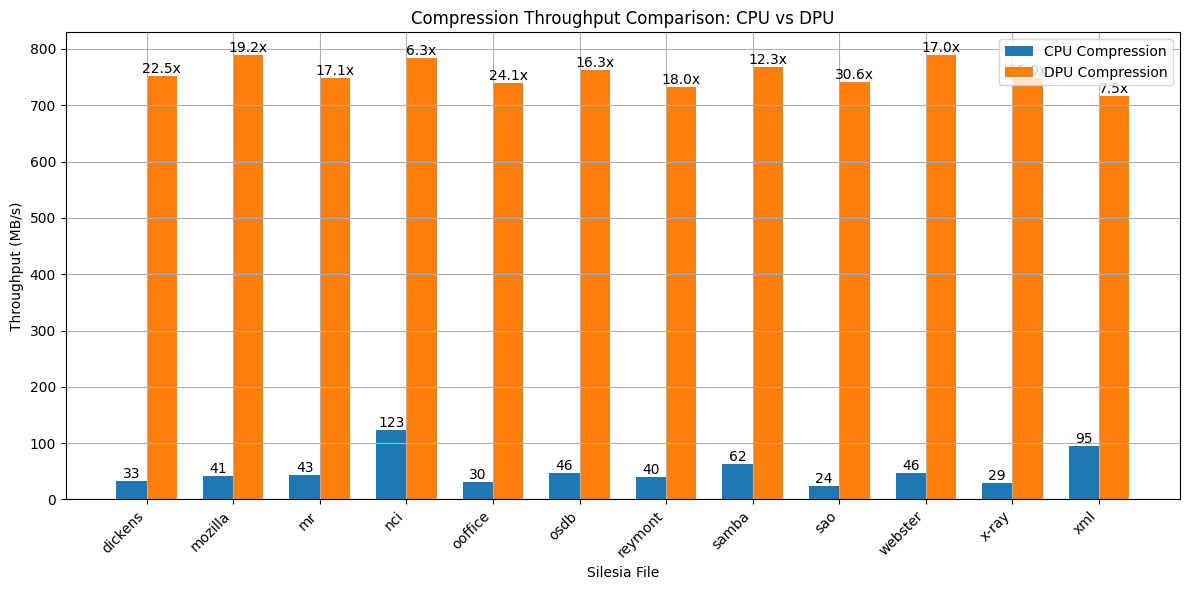

Figure saved to ../../tex/figures/za-evaluation/de_compression_Decompression_cpu_vs_dpu.png


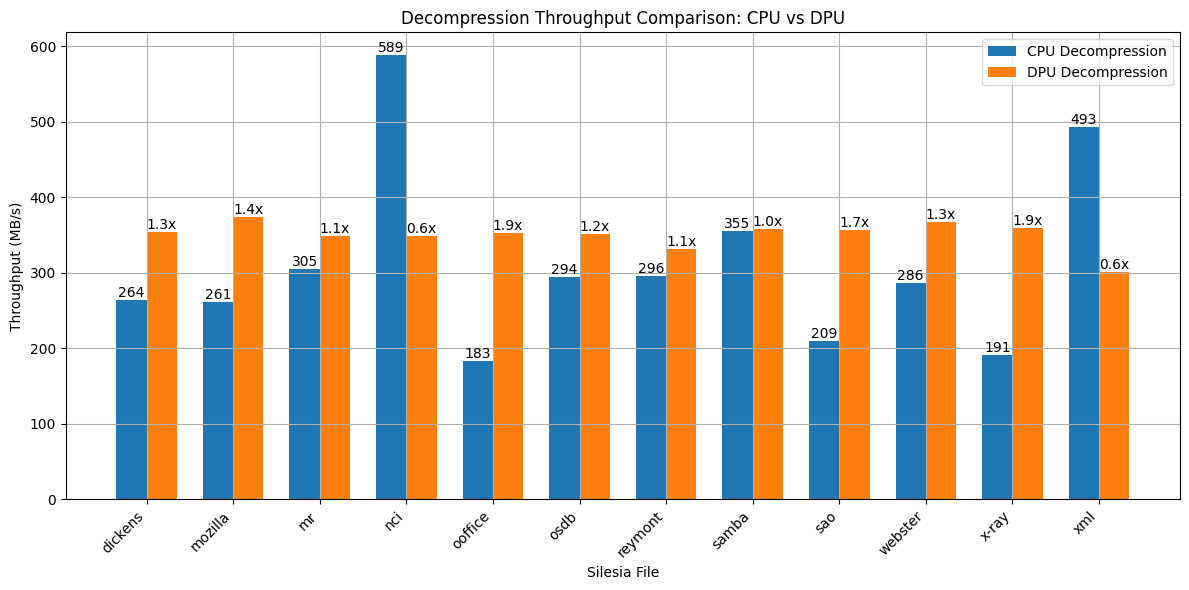

In [11]:
# Use glob to find the 'orig' CSV file in the latest directory
orig_cpu_csv_path = glob.glob(f'{latest_dir}cpu/*orig*.csv')[0]

# Load the CSV file into a DataFrame
orig_cpu_df = pd.read_csv(orig_cpu_csv_path, delim_whitespace=True)

# Drop the 'Dataset' column since we are focusing on a single dataset for now
cpu_data = orig_cpu_df.drop(columns=['codec', 'level', 'param', 'cmem', 'dmem', 'cstack', 'dstack', 'time'])

# Group by 'Configuration' and 'Filename', get the averages across all runs
dpu_data = orig_df.groupby(['Configuration', 'Filename']).mean().reset_index()

# Calculate megabytes per second for CPU data
cpu_data['c_mb_per_s'] = cpu_data['size'] / (cpu_data['ctime'] * 1024 * 1024)
cpu_data['d_mb_per_s'] = cpu_data['size'] / (cpu_data['dtime'] * 1024 * 1024)
cpu_data['Type'] = 'CPU'

# Process DPU data to match the format
dpu_data['Type'] = 'DPU'
dpu_data['c_mb_per_s'] = np.where(dpu_data['Configuration'] == 'CDFLT', dpu_data['Throughput (MB/s)'], 0)
dpu_data['d_mb_per_s'] = np.where(dpu_data['Configuration'] == 'DDFLT', dpu_data['Throughput (MB/s)'], 0)

# Ensure the columns match for merging
cpu_data = cpu_data.rename(columns={'dataset': 'Filename'})
dpu_data = dpu_data.rename(columns={'Filename': 'Filename'})

# Combine the datasets
combined_data = pd.concat([cpu_data, dpu_data])

# Create a long-form DataFrame for plotting
data_long = pd.melt(combined_data, id_vars=['Filename', 'Type'], value_vars=['c_mb_per_s', 'd_mb_per_s'],
                    var_name='Operation', value_name='Throughput_MBps')

# Filter out zero values
data_long = data_long[data_long['Throughput_MBps'] > 0]

# Map the operation labels to be more descriptive
data_long['Operation'] = data_long['Operation'].map({'c_mb_per_s': 'Compression', 'd_mb_per_s': 'Decompression'})

# Create plots for compression and decompression
for operation in ['Compression', 'Decompression']:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Filter the data for the current operation
    operation_data = data_long[data_long['Operation'] == operation]
    
    # Get the unique file names and types
    filenames = operation_data['Filename'].unique()
    types = operation_data['Type'].unique()
    
    # Create an array for the positions of the bars
    x = np.arange(len(filenames))
    bar_width = 0.35

    # Plot bars for each type (CPU and DPU)
    for i, type_ in enumerate(types):
        type_data = operation_data[operation_data['Type'] == type_]
        bars = ax.bar(x + i * bar_width, type_data['Throughput_MBps'], bar_width, label=f'{type_} {operation}')
        
        # Add values on top of the bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if type_ == 'DPU':
                # Get the corresponding CPU value
                cpu_value = operation_data[(operation_data['Filename'] == filenames[j]) & 
                                           (operation_data['Type'] == 'CPU')]['Throughput_MBps'].values[0]
                relative_diff = height / cpu_value
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{relative_diff:.1f}x', ha='center', va='bottom')
            else:
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')
    
    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Silesia File')
    ax.set_ylabel('Throughput (MB/s)')
    ax.set_title(f'{operation} Throughput Comparison: CPU vs DPU')
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(filenames, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    
    # Tighten the plot
    plt.tight_layout()
    
    # Save the figure
    save_figure(fig, f"de_compression_{operation}_cpu_vs_dpu.png")
    
    # Show the plot
    plt.show()